In [1]:
# imports
import json
import jsonlines
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import figure
import seaborn as sb
from statistics import mean
import warnings

# Synthetic data experiments

In [6]:
BORDA_BASE = "../WorkshopExperiments/data/history_file_baseline_s1.json"
BORDA_LOT = "../WorkshopExperiments/data/history_file_product_alloc_borda_s1.json"
BORDA_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_borda_s1.json"
BORDA_LEAST = "../WorkshopExperiments/data/history_file_least_fair_borda_s1.json"

COPELAND_BASE = "../WorkshopExperiments/data/history_file_baseline_s1.json"
COPELAND_LOT = "../WorkshopExperiments/data/history_file_product_alloc_copeland_s1.json"
COPELAND_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_copeland_s1.json"
COPELAND_LEAST = "../WorkshopExperiments/data/history_file_least_fair_copeland_s1.json"

RP_BASE = "../WorkshopExperiments/data/history_file_baseline_s1.json"
RP_LOT = "../WorkshopExperiments/data/history_file_product_alloc_rankedpairs_s1.json"
RP_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_ranked_pairs_s1.json"
RP_LEAST = "../WorkshopExperiments/data/history_file_least_fair_rankedpairs_s1.json"

WR_BASE = "../WorkshopExperiments/data/history_file_baseline_s1.json"
WR_LEAST = "../WorkshopExperiments/data/history_file_least_fair_rescore_s1.json"
WR_LOT = "../WorkshopExperiments/data/history_file_product_alloc_rescore_s1.json"
WR_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_weighted_s1.json"

recs_file = "../WorkshopExperiments/data/recs_s1.csv"
items_file = "../WorkshopExperiments/data/items_s1.csv"

In [7]:
# reads recommender and item files
recommender = pd.read_csv(recs_file, names=["User","Item","Score"])
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])

In [8]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_BASE, BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_BASE,
                 COPELAND_LEAST, COPELAND_LOT, COPELAND_WEIGHT, RP_BASE, RP_LEAST,
                 RP_LOT, RP_WEIGHT, WR_BASE, WR_LEAST, WR_LOT, WR_WEIGHT]


mechanisms = ['Borda Baseline','Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair', 'Copeland Baseline','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Baseline','Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product',
                  'Weighted Rescore Baseline', 'Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Weighted Rescore Least Fair']

In [9]:
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

In [10]:
for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [11]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicitly determined. Defaulting to integer...")
        var = int(var)
    return var

# get recommendation score based on user and item ids
def lookupscore(user, item):
    score = recommender.loc[(recommender.User == typecast(recommender.User, user)) & (recommender.Item == typecast(recommender.Item, item))]
    if not score.empty:
        score = score['Score']
    else:
        score = 0.0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [31]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['0'] == 0) & (alloc_df['1'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc


In [13]:
def plot_multi(fair=False, alloc=False, regret=False, features=[], include_none=False):
    to_analyze = []
    if fair:
        to_analyze.append("Fairness")
    if regret:
        to_analyze.append("Fairness Regret")
    if alloc:
        to_analyze.append("Allocation")

    for label in to_analyze:
        experiment_data = []
        for history in processed_histories:
            choice, alloc = process_names(history)
            if label=="Fairness" or label=="Fairness Regret":
                experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
            elif label=="Allocation":
                experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
                if include_none is False:
                    if not experiment['none'][1:].any():
                        experiment.drop('none', axis=1, inplace=True)
                experiment = experiment.cumsum()
            if label=="Fairness Regret":
                regret = (1-experiment).cumsum()
                for feature in features:
                    experiment[feature] = regret[feature]
            experiment["Choice Mech"] = choice
            experiment["Allocation Mech"] = alloc
            experiment_data.append(experiment)
        experiments = pd.concat(experiment_data)
        experiments["Time"] = experiments.index
        experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=features,var_name='Agent', value_name=label)
        plt = sb.FacetGrid(experiments,
                           row="Allocation Mech",
                           col="Choice Mech",
                           margin_titles=True,
                           height=4,
                           aspect=1)
        # it's just the same plot lmao oops
        plt.map(sb.catplot, data=experiments, y=label, x="Agent", order=["1","2"], kind="box")
        plt.figure.subplots_adjust(wspace=.02, hspace=.02)

In [20]:
to_analyze = ["Fairness"]
for label in to_analyze:
    experiment_data = []
    for history in processed_histories:
        choice, alloc = process_names(history)
        if label=="Fairness" or label=="Fairness Regret":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
        elif label=="Allocation":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
            if include_none is False:
                if not experiment['none'][1:].any():
                    experiment.drop('none', axis=1, inplace=True)
            experiment = experiment.cumsum()
        if label=="Fairness Regret":
            regret = (1-experiment).cumsum()
            for feature in features:
                experiment[feature] = regret[feature]
        experiment["Choice Mech"] = choice
        experiment["Allocation Mech"] = alloc
        experiment_data.append(experiment)
    experiments = pd.concat(experiment_data)
    experiments["Time"] = experiments.index
    experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["1","2"],var_name='Agent', value_name=label)
    experiments["NDCG"] = experiments.apply(lambda x: ndcg_results[x["Choice Mech"]+" "+x["Allocation Mech"]]["NDCG"][int(x["Time"])], axis=1)

KeyError: '2'

In [16]:
to_analyze = ["Fairness"]
for label in to_analyze:
    experiment_data = []
    for history in processed_histories:
        choice, alloc = process_names(history)
        if label=="Fairness" or label=="Fairness Regret":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
            experiment = experiment.cumsum()
        elif label=="Allocation":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
            if include_none is False:
                if not experiment['none'][1:].any():
                    experiment.drop('none', axis=1, inplace=True)
            experiment = experiment.cumsum()
        if label=="Fairness Regret":
            regret = (1-experiment).cumsum()
            for feature in features:
                experiment[feature] = regret[feature]
        experiment["Choice Mech"] = choice
        experiment["Allocation Mech"] = alloc
        experiment_data.append(experiment)
    experiments = pd.concat(experiment_data)
    experiments["Time"] = experiments.index
    new_fair = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["1","2"],var_name='Agent', value_name="Cumulative Fairness")

In [15]:
experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
    experiment = experiment.cumsum()
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
alloc_a = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["1","2"],var_name='Agent', value_name="Cumulative Alloc")

experiment_data = []
for history in processed_histories:
    choice, alloc = process_names(history)
    experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
    experiment["Choice Mech"] = choice
    experiment["Allocation Mech"] = alloc
    experiment_data.append(experiment)
experiments = pd.concat(experiment_data)
experiments["Time"] = experiments.index
alloc_b = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["1","2"],var_name='Agent', value_name="Alloc")

In [17]:
experiment

1           2       Choice Mech Allocation Mech
0      1.000000    1.000000  Weighted Rescore      Least Fair
1      1.000000    1.400000  Weighted Rescore      Least Fair
2      1.000000    1.600000  Weighted Rescore      Least Fair
3      1.266667    1.866667  Weighted Rescore      Least Fair
4      1.566667    2.066667  Weighted Rescore      Least Fair
..          ...         ...               ...             ...
495  252.827695  295.993374  Weighted Rescore      Least Fair
496  253.299695  296.517374  Weighted Rescore      Least Fair
497  253.771695  297.033374  Weighted Rescore      Least Fair
498  254.247695  297.553374  Weighted Rescore      Least Fair
499  254.735695  298.097374  Weighted Rescore      Least Fair

[500 rows x 4 columns]

In [18]:
alloc_a

Allocation Mech       Choice Mech  Time Agent  Cumulative Alloc
0            Baseline             Borda     0     1          0.000000
1            Baseline             Borda     1     1          0.000000
2            Baseline             Borda     2     1          0.000000
3            Baseline             Borda     3     1          0.000000
4            Baseline             Borda     4     1          0.000000
...               ...               ...   ...   ...               ...
15995      Least Fair  Weighted Rescore   495     2        328.897964
15996      Least Fair  Weighted Rescore   496     2        329.595713
15997      Least Fair  Weighted Rescore   497     2        330.367344
15998      Least Fair  Weighted Rescore   498     2        331.196258
15999      Least Fair  Weighted Rescore   499     2        331.819814

[16000 rows x 5 columns]

In [21]:
experiments

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG
0            Baseline             Borda     0     1     1.000  0.974900
1            Baseline             Borda     1     1     0.000  0.972287
2            Baseline             Borda     2     1     0.000  0.967002
3            Baseline             Borda     3     1     0.000  0.994877
4            Baseline             Borda     4     1     0.100  0.964130
...               ...               ...   ...   ...       ...       ...
15995      Least Fair  Weighted Rescore   495     2     0.508  0.625200
15996      Least Fair  Weighted Rescore   496     2     0.524  0.980360
15997      Least Fair  Weighted Rescore   497     2     0.516  0.966488
15998      Least Fair  Weighted Rescore   498     2     0.520  0.783597
15999      Least Fair  Weighted Rescore   499     2     0.544  0.988278

[16000 rows x 6 columns]

In [24]:
big_table = pd.concat([experiments, alloc_a["Cumulative Alloc"], alloc_b["Alloc"], new_fair["Cumulative Fairness"]], axis=1)

In [25]:
big_table

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
0            Baseline             Borda     0     1     1.000  0.974900   
1            Baseline             Borda     1     1     0.000  0.972287   
2            Baseline             Borda     2     1     0.000  0.967002   
3            Baseline             Borda     3     1     0.000  0.994877   
4            Baseline             Borda     4     1     0.100  0.964130   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2     0.508  0.625200   
15996      Least Fair  Weighted Rescore   496     2     0.524  0.980360   
15997      Least Fair  Weighted Rescore   497     2     0.516  0.966488   
15998      Least Fair  Weighted Rescore   498     2     0.520  0.783597   
15999      Least Fair  Weighted Rescore   499     2     0.544  0.988278   

       Cumulative Alloc     Alloc  Cumulative Fairness  
0              0.000000  0.000000             1.000000  
1              0.000000  0.000000             1.000000  
2              0.000000  0.000000             1.000000  
3              0.000000  0.000000             1.000000  
4              0.000000  0.000000             1.100000  
...                 ...       ...                  ...  
15995        328.897964  0.951434           295.993374  
15996        329.595713  0.697749           296.517374  
15997        330.367344  0.771631           297.033374  
15998        331.196258  0.828914           297.553374  
15999        331.819814  0.623556           298.097374  

[16000 rows x 9 columns]

In [26]:
no_baseline = big_table[big_table["Allocation Mech"] != "Baseline"]

In [27]:
no_baseline

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
500           Lottery             Borda     0     1  1.000000  0.749757   
501           Lottery             Borda     1     1  0.000000  0.972287   
502           Lottery             Borda     2     1  0.000000  0.756833   
503           Lottery             Borda     3     1  0.266667  0.546375   
504           Lottery             Borda     4     1  0.600000  0.811417   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2  0.508000  0.625200   
15996      Least Fair  Weighted Rescore   496     2  0.524000  0.980360   
15997      Least Fair  Weighted Rescore   497     2  0.516000  0.966488   
15998      Least Fair  Weighted Rescore   498     2  0.520000  0.783597   
15999      Least Fair  Weighted Rescore   499     2  0.544000  0.988278   

       Cumulative Alloc     Alloc  Cumulative Fairness  
500            0.000000  0.000000             1.000000  
501            1.000000  1.000000             1.000000  
502            2.000000  1.000000             1.000000  
503            3.000000  1.000000             1.266667  
504            3.000000  0.000000             1.866667  
...                 ...       ...                  ...  
15995        328.897964  0.951434           295.993374  
15996        329.595713  0.697749           296.517374  
15997        330.367344  0.771631           297.033374  
15998        331.196258  0.828914           297.553374  
15999        331.819814  0.623556           298.097374  

[12000 rows x 9 columns]

In [28]:
baseline = big_table.loc[big_table["Allocation Mech"] == "Baseline"]["Cumulative Fairness"]

In [29]:
no_baseline["Baseline Cumulative Fairness"] = np.tile(baseline, len(no_baseline)//len(baseline))

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/1031430100.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_baseline["Baseline Cumulative Fairness"] = np.tile(baseline, len(no_baseline)//len(baseline))


In [30]:
def calc_efficiency(row):
    if row["Cumulative Alloc"] > 0:
        return (row["Cumulative Fairness"]-row["Baseline Cumulative Fairness"])/row["Cumulative Alloc"]
    else:
        return pd.NA

In [31]:
no_baseline["Efficiency"] = no_baseline.apply(lambda x: calc_efficiency(x), axis=1)

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/1079150928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_baseline["Efficiency"] = no_baseline.apply(lambda x: calc_efficiency(x), axis=1)


In [34]:
no_baseline

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
500           Lottery             Borda     0     1  1.000000  0.749757   
501           Lottery             Borda     1     1  0.000000  0.972287   
502           Lottery             Borda     2     1  0.000000  0.756833   
503           Lottery             Borda     3     1  0.266667  0.546375   
504           Lottery             Borda     4     1  0.600000  0.811417   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2  0.508000  0.625200   
15996      Least Fair  Weighted Rescore   496     2  0.524000  0.980360   
15997      Least Fair  Weighted Rescore   497     2  0.516000  0.966488   
15998      Least Fair  Weighted Rescore   498     2  0.520000  0.783597   
15999      Least Fair  Weighted Rescore   499     2  0.544000  0.988278   

       Cumulative Alloc     Alloc  Cumulative Fairness  \
500            0.000000  0.000000             1.000000   
501            1.000000  1.000000             1.000000   
502            2.000000  1.000000             1.000000   
503            3.000000  1.000000             1.266667   
504            3.000000  0.000000             1.866667   
...                 ...       ...                  ...   
15995        328.897964  0.951434           295.993374   
15996        329.595713  0.697749           296.517374   
15997        330.367344  0.771631           297.033374   
15998        331.196258  0.828914           297.553374   
15999        331.819814  0.623556           298.097374   

       Baseline Cumulative Fairness Efficiency  
500                        1.000000       <NA>  
501                        1.000000        0.0  
502                        1.000000        0.0  
503                        1.000000   0.088889  
504                        1.100000   0.255556  
...                             ...        ...  
15995                    111.470371   0.561034  
15996                    111.666371   0.560842  
15997                    111.862371     0.5605  
15998                    112.062371   0.560064  
15999                    112.270371   0.560024  

[12000 rows x 11 columns]

In [35]:
def calc_efficiency(row):
    if row["Cumulative Alloc"] > 0:
        return (row["Cumulative Fairness"]-row["Baseline Cumulative Fairness"])/row["Cumulative Alloc"]
    else:
        return pd.NA

In [36]:
no_baseline["Efficiency"] = no_baseline.apply(lambda x: calc_efficiency(x), axis=1)

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/1079150928.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_baseline["Efficiency"] = no_baseline.apply(lambda x: calc_efficiency(x), axis=1)


In [37]:
no_baseline

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
500           Lottery             Borda     0     1  1.000000  0.749757   
501           Lottery             Borda     1     1  0.000000  0.972287   
502           Lottery             Borda     2     1  0.000000  0.756833   
503           Lottery             Borda     3     1  0.266667  0.546375   
504           Lottery             Borda     4     1  0.600000  0.811417   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2  0.508000  0.625200   
15996      Least Fair  Weighted Rescore   496     2  0.524000  0.980360   
15997      Least Fair  Weighted Rescore   497     2  0.516000  0.966488   
15998      Least Fair  Weighted Rescore   498     2  0.520000  0.783597   
15999      Least Fair  Weighted Rescore   499     2  0.544000  0.988278   

       Cumulative Alloc     Alloc  Cumulative Fairness  \
500            0.000000  0.000000             1.000000   
501            1.000000  1.000000             1.000000   
502            2.000000  1.000000             1.000000   
503            3.000000  1.000000             1.266667   
504            3.000000  0.000000             1.866667   
...                 ...       ...                  ...   
15995        328.897964  0.951434           295.993374   
15996        329.595713  0.697749           296.517374   
15997        330.367344  0.771631           297.033374   
15998        331.196258  0.828914           297.553374   
15999        331.819814  0.623556           298.097374   

       Baseline Cumulative Fairness Efficiency  
500                        1.000000       <NA>  
501                        1.000000        0.0  
502                        1.000000        0.0  
503                        1.000000   0.088889  
504                        1.100000   0.255556  
...                             ...        ...  
15995                    111.470371   0.561034  
15996                    111.666371   0.560842  
15997                    111.862371     0.5605  
15998                    112.062371   0.560064  
15999                    112.270371   0.560024  

[12000 rows x 11 columns]

<Axes: xlabel='Time', ylabel='Cumulative Alloc'>

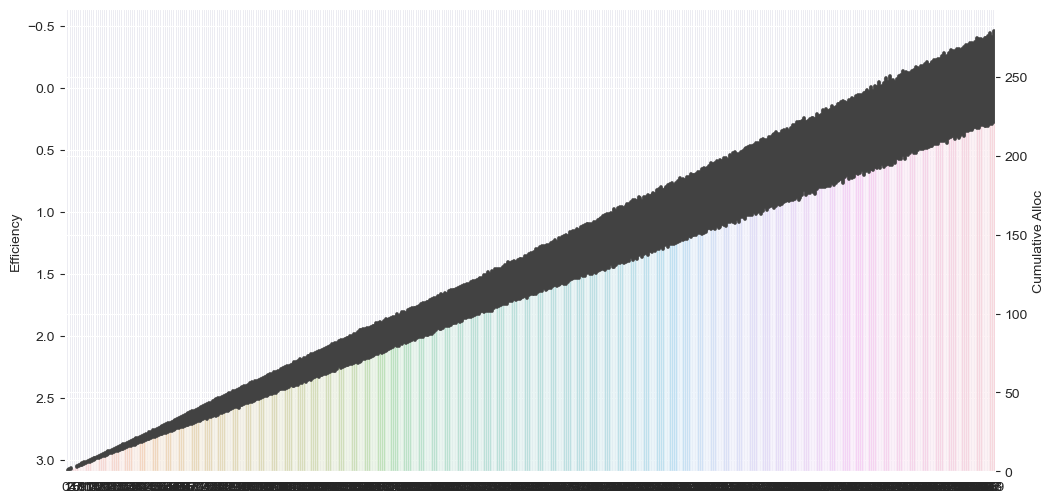

In [27]:
fig, ax1 = plt.subplots(figsize=(12,6))
sb.lineplot(data = no_baseline["Efficiency"], sort = False, ax=ax1)
ax2 = ax1.twinx()
sb.barplot(data = no_baseline, x="Time", y="Cumulative Alloc", alpha=0.5, ax=ax2)

In [38]:
x_no_baseline = no_baseline.dropna()

In [46]:
def facetgrid_two_axes(data: pd.DataFrame, x_name: str, y1_name: str, y2_name: str, color,label):
    fig = plt.figure()
    ax1 = fig.add_subplot()
    sb.lineplot(x=data[x_name], y=data[y1_name], alpha=.7, ax=ax1, hue=hue, color=color, label=label)
    ax1.set_ylabel(y1_name)

    ax2 = ax1.twinx()
    sb.barplot(data[x_name], data[y2_name], alpha=.7, ax=ax2, hue=hue, color=color, label=label)
    ax2.set_ylabel(y2_name)

<Axes: xlabel='Time', ylabel='Efficiency'>

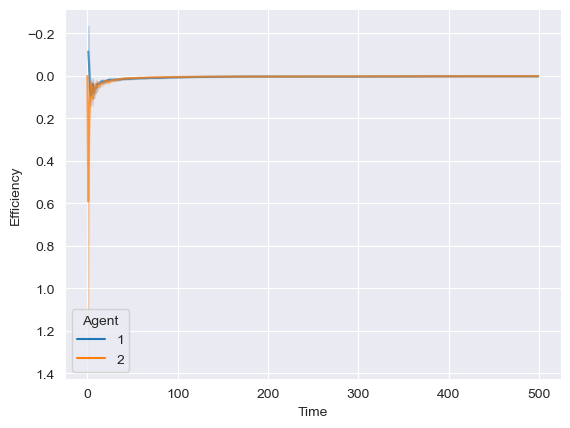

In [54]:
sb.lineplot(data=no_baseline, x="Time", y="Efficiency", alpha=.7, hue="Agent")

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_63593/45240864.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.lineplot(data=no_baseline[no_baseline["Allocation Mech"] == "Lottery"][no_baseline["Choice Mech"] == "Borda"], x="Time", y="Efficiency", hue="Agent", ax=ax)


<Axes: xlabel='Time', ylabel='Efficiency'>

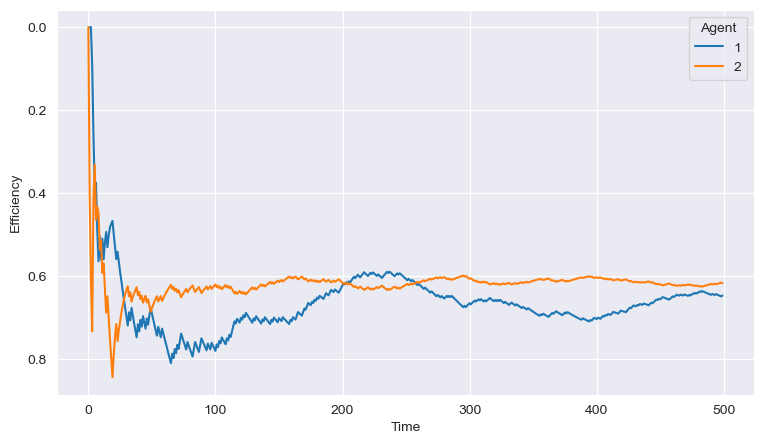

In [63]:
fig, ax = plt.subplots(figsize=(9, 5))
sb.lineplot(data=no_baseline[no_baseline["Allocation Mech"] == "Lottery"][no_baseline["Choice Mech"] == "Borda"], x="Time", y="Efficiency", hue="Agent", ax=ax)

In [27]:
no_baseline

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
500           Lottery             Borda     0     1  1.000000  0.749757   
501           Lottery             Borda     1     1  0.000000  0.972287   
502           Lottery             Borda     2     1  0.000000  0.756833   
503           Lottery             Borda     3     1  0.266667  0.546375   
504           Lottery             Borda     4     1  0.600000  0.811417   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2  0.508000  0.625200   
15996      Least Fair  Weighted Rescore   496     2  0.524000  0.980360   
15997      Least Fair  Weighted Rescore   497     2  0.516000  0.966488   
15998      Least Fair  Weighted Rescore   498     2  0.520000  0.783597   
15999      Least Fair  Weighted Rescore   499     2  0.544000  0.988278   

       Cumulative Alloc     Alloc  Baseline Fairness Efficiency  
500            0.000000  0.000000              1.000       <NA>  
501            1.000000  1.000000              0.000        0.0  
502            2.000000  1.000000              0.000        0.0  
503            3.000000  1.000000              0.000   0.088889  
504            3.000000  0.000000              0.100   0.166667  
...                 ...       ...                ...        ...  
15995        328.897964  0.951434              0.196   0.000949  
15996        329.595713  0.697749              0.196   0.000995  
15997        330.367344  0.771631              0.196   0.000969  
15998        331.196258  0.828914              0.200   0.000966  
15999        331.819814  0.623556              0.208   0.001013  

[12000 rows x 10 columns]

In [39]:
no_baseline[no_baseline["Allocation Mech"] == "Least Fair"][no_baseline["Choice Mech"] == "Copeland"]

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/3613986289.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_baseline[no_baseline["Allocation Mech"] == "Least Fair"][no_baseline["Choice Mech"] == "Copeland"]


Allocation Mech Choice Mech  Time Agent  Fairness      NDCG  \
2500       Least Fair    Copeland     0     1  1.000000  0.974900   
2501       Least Fair    Copeland     1     1  0.000000  0.972287   
2502       Least Fair    Copeland     2     1  0.000000  0.630275   
2503       Least Fair    Copeland     3     1  0.533333  0.994877   
2504       Least Fair    Copeland     4     1  0.500000  0.773393   
...               ...         ...   ...   ...       ...       ...   
10995      Least Fair    Copeland   495     2  0.672000  0.625785   
10996      Least Fair    Copeland   496     2  0.684000  0.726434   
10997      Least Fair    Copeland   497     2  0.680000  0.825861   
10998      Least Fair    Copeland   498     2  0.684000  0.810257   
10999      Least Fair    Copeland   499     2  0.700000  0.533284   

       Cumulative Alloc  Alloc  Cumulative Fairness  \
2500                0.0    0.0             1.000000   
2501                1.0    1.0             1.000000   
2502                2.0    1.0             1.000000   
2503                2.0    0.0             1.533333   
2504                2.0    0.0             2.033333   
...                 ...    ...                  ...   
10995             278.0    1.0           341.694409   
10996             279.0    1.0           342.378409   
10997             280.0    1.0           343.058409   
10998             280.0    0.0           343.742409   
10999             280.0    0.0           344.442409   

       Baseline Cumulative Fairness Efficiency  
2500                       1.000000       <NA>  
2501                       1.000000        0.0  
2502                       1.000000        0.0  
2503                       1.000000   0.266667  
2504                       1.100000   0.466667  
...                             ...        ...  
10995                    111.470371   0.828144  
10996                    111.666371   0.826925  
10997                    111.862371     0.8257  
10998                    112.062371   0.827429  
10999                    112.270371   0.829186  

[1000 rows x 11 columns]

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_63593/2725143147.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.lineplot(data=no_baseline[no_baseline["Allocation Mech"] == "Least Fair"][no_baseline["Choice Mech"] == "Copeland"], x="Time", y="Efficiency", hue="Agent", ax=ax)


<Axes: xlabel='Time', ylabel='Efficiency'>

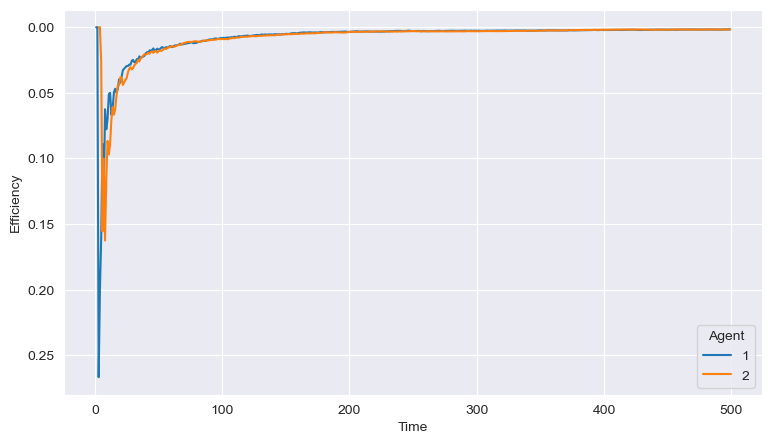

In [36]:
fig, ax = plt.subplots(figsize=(9, 5))
sb.lineplot(data=no_baseline[no_baseline["Allocation Mech"] == "Least Fair"][no_baseline["Choice Mech"] == "Copeland"], x="Time", y="Efficiency", hue="Agent", ax=ax)

In [66]:
no_baseline

Allocation Mech       Choice Mech  Time Agent  Fairness      NDCG  \
500           Lottery             Borda     0     1  1.000000  0.749757   
501           Lottery             Borda     1     1  0.000000  0.972287   
502           Lottery             Borda     2     1  0.000000  0.756833   
503           Lottery             Borda     3     1  0.266667  0.546375   
504           Lottery             Borda     4     1  0.600000  0.811417   
...               ...               ...   ...   ...       ...       ...   
15995      Least Fair  Weighted Rescore   495     2  0.508000  0.625200   
15996      Least Fair  Weighted Rescore   496     2  0.524000  0.980360   
15997      Least Fair  Weighted Rescore   497     2  0.516000  0.966488   
15998      Least Fair  Weighted Rescore   498     2  0.520000  0.783597   
15999      Least Fair  Weighted Rescore   499     2  0.544000  0.988278   

       Cumulative Alloc     Alloc  Cumulative Fairness  \
500            0.000000  0.000000             1.000000   
501            1.000000  1.000000             1.000000   
502            2.000000  1.000000             1.000000   
503            3.000000  1.000000             1.266667   
504            3.000000  0.000000             1.866667   
...                 ...       ...                  ...   
15995        328.897964  0.951434           295.993374   
15996        329.595713  0.697749           296.517374   
15997        330.367344  0.771631           297.033374   
15998        331.196258  0.828914           297.553374   
15999        331.819814  0.623556           298.097374   

       Baseline Cumulative Fairness Efficiency  
500                        1.000000       <NA>  
501                        1.000000        0.0  
502                        1.000000        0.0  
503                        1.000000   0.088889  
504                        1.100000   0.255556  
...                             ...        ...  
15995                    111.470371   0.561034  
15996                    111.666371   0.560842  
15997                    111.862371     0.5605  
15998                    112.062371   0.560064  
15999                    112.270371   0.560024  

[12000 rows x 11 columns]

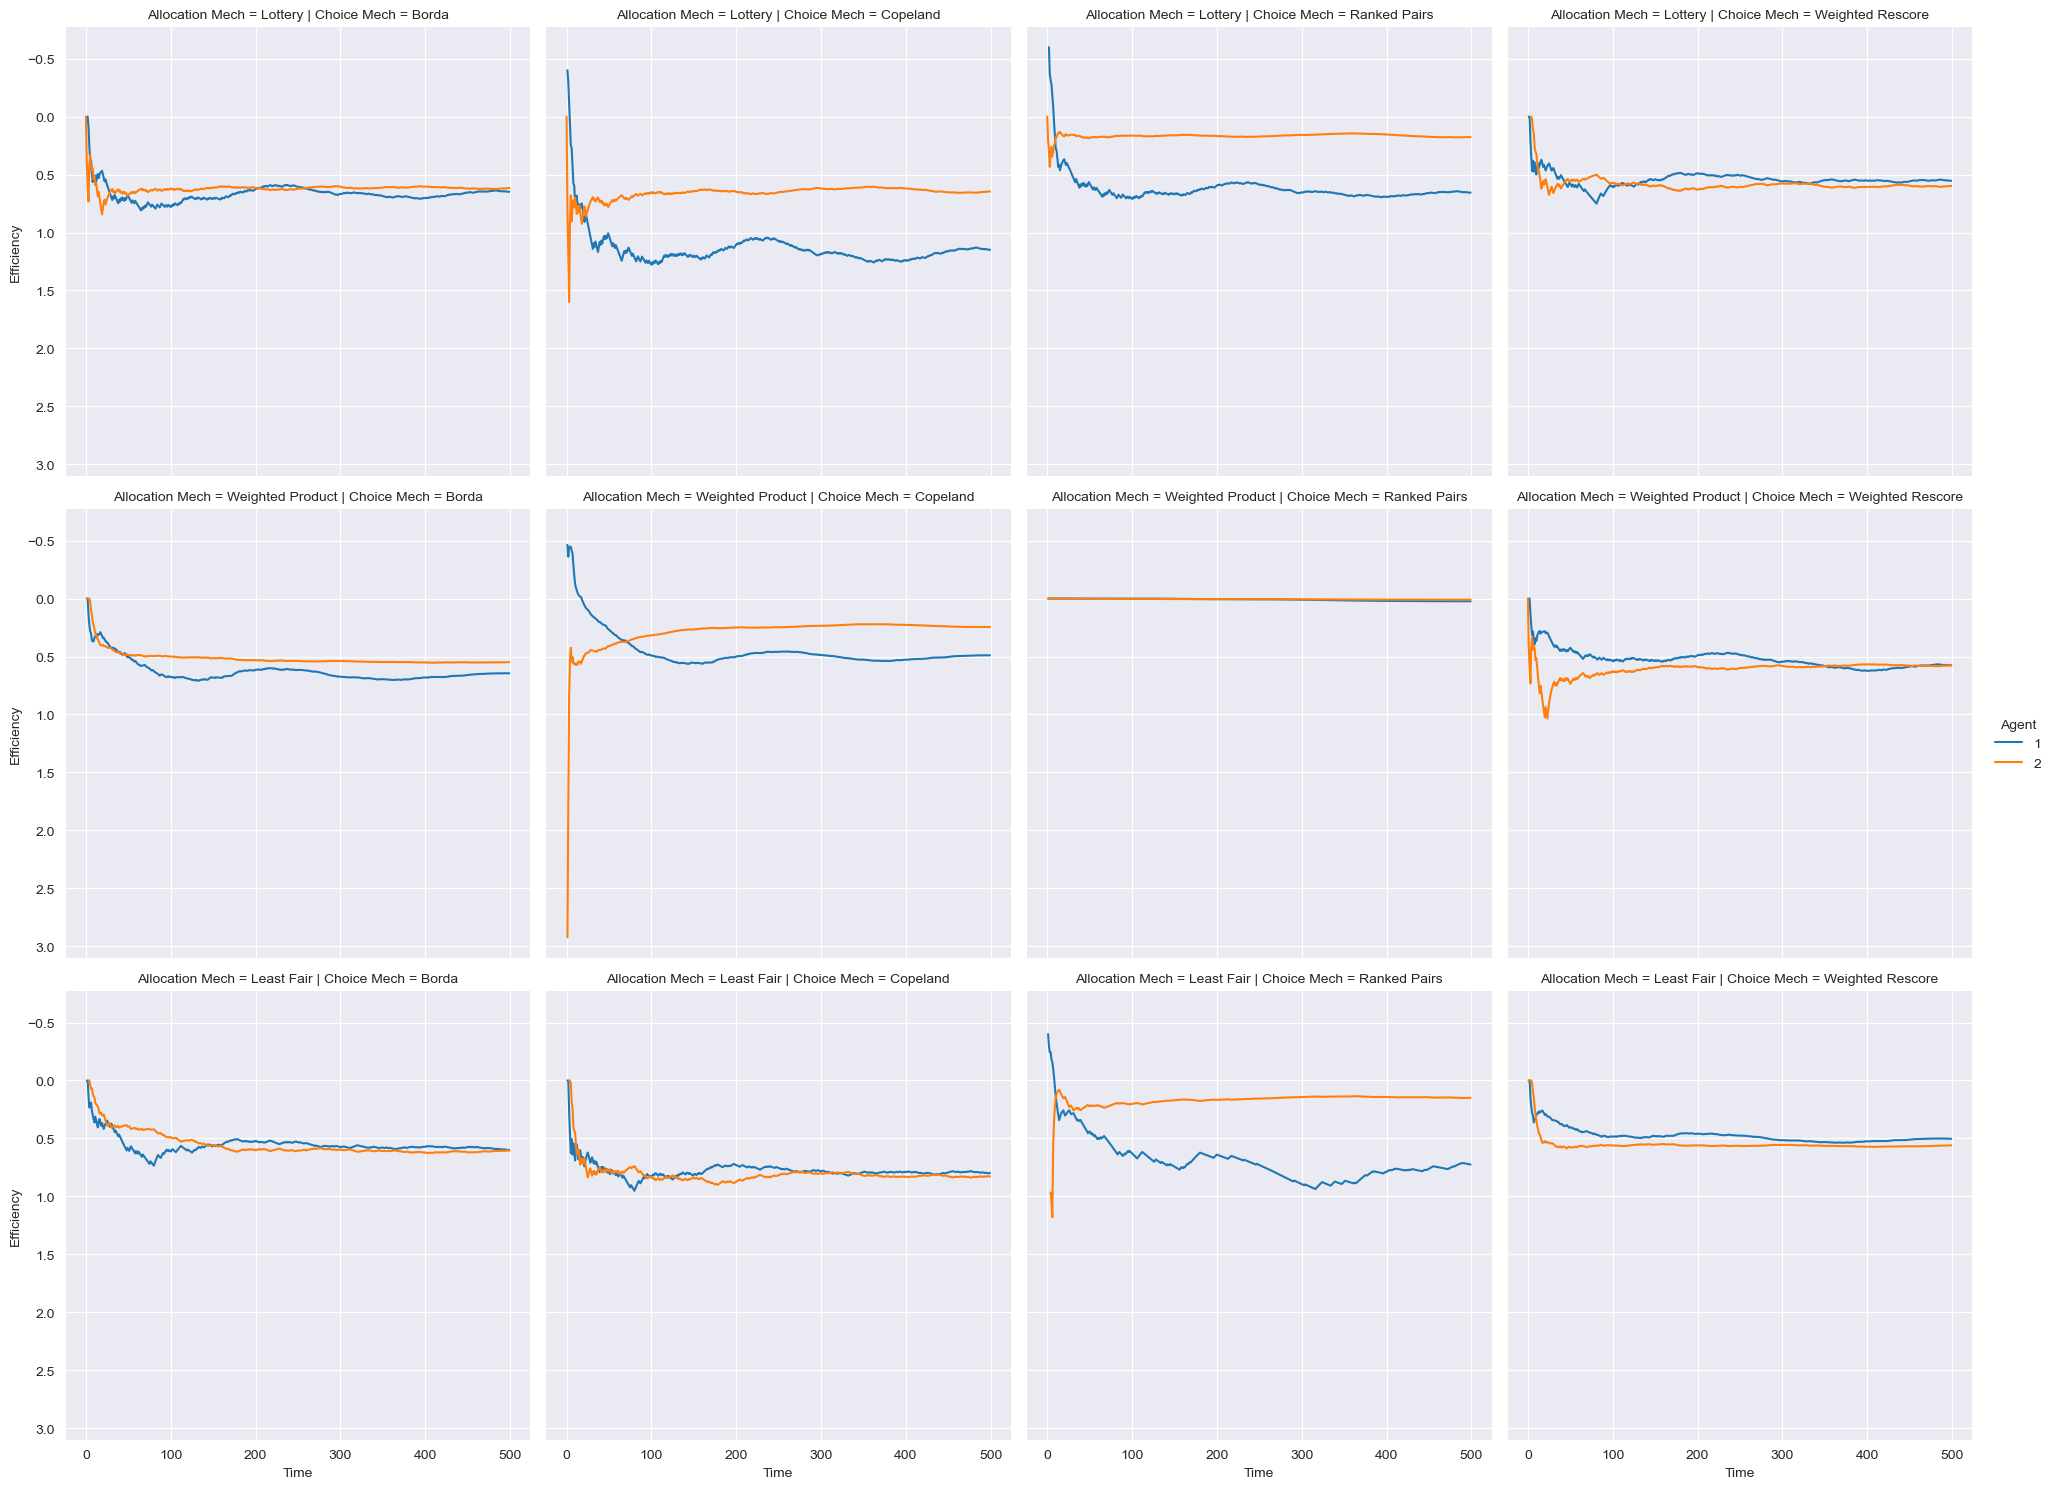

In [68]:
sb.relplot(data=no_baseline, col="Choice Mech", row="Allocation Mech", x="Time", y="Efficiency", hue="Agent", kind="line")

ValueError: Could not interpret value `Time` for parameter `x`

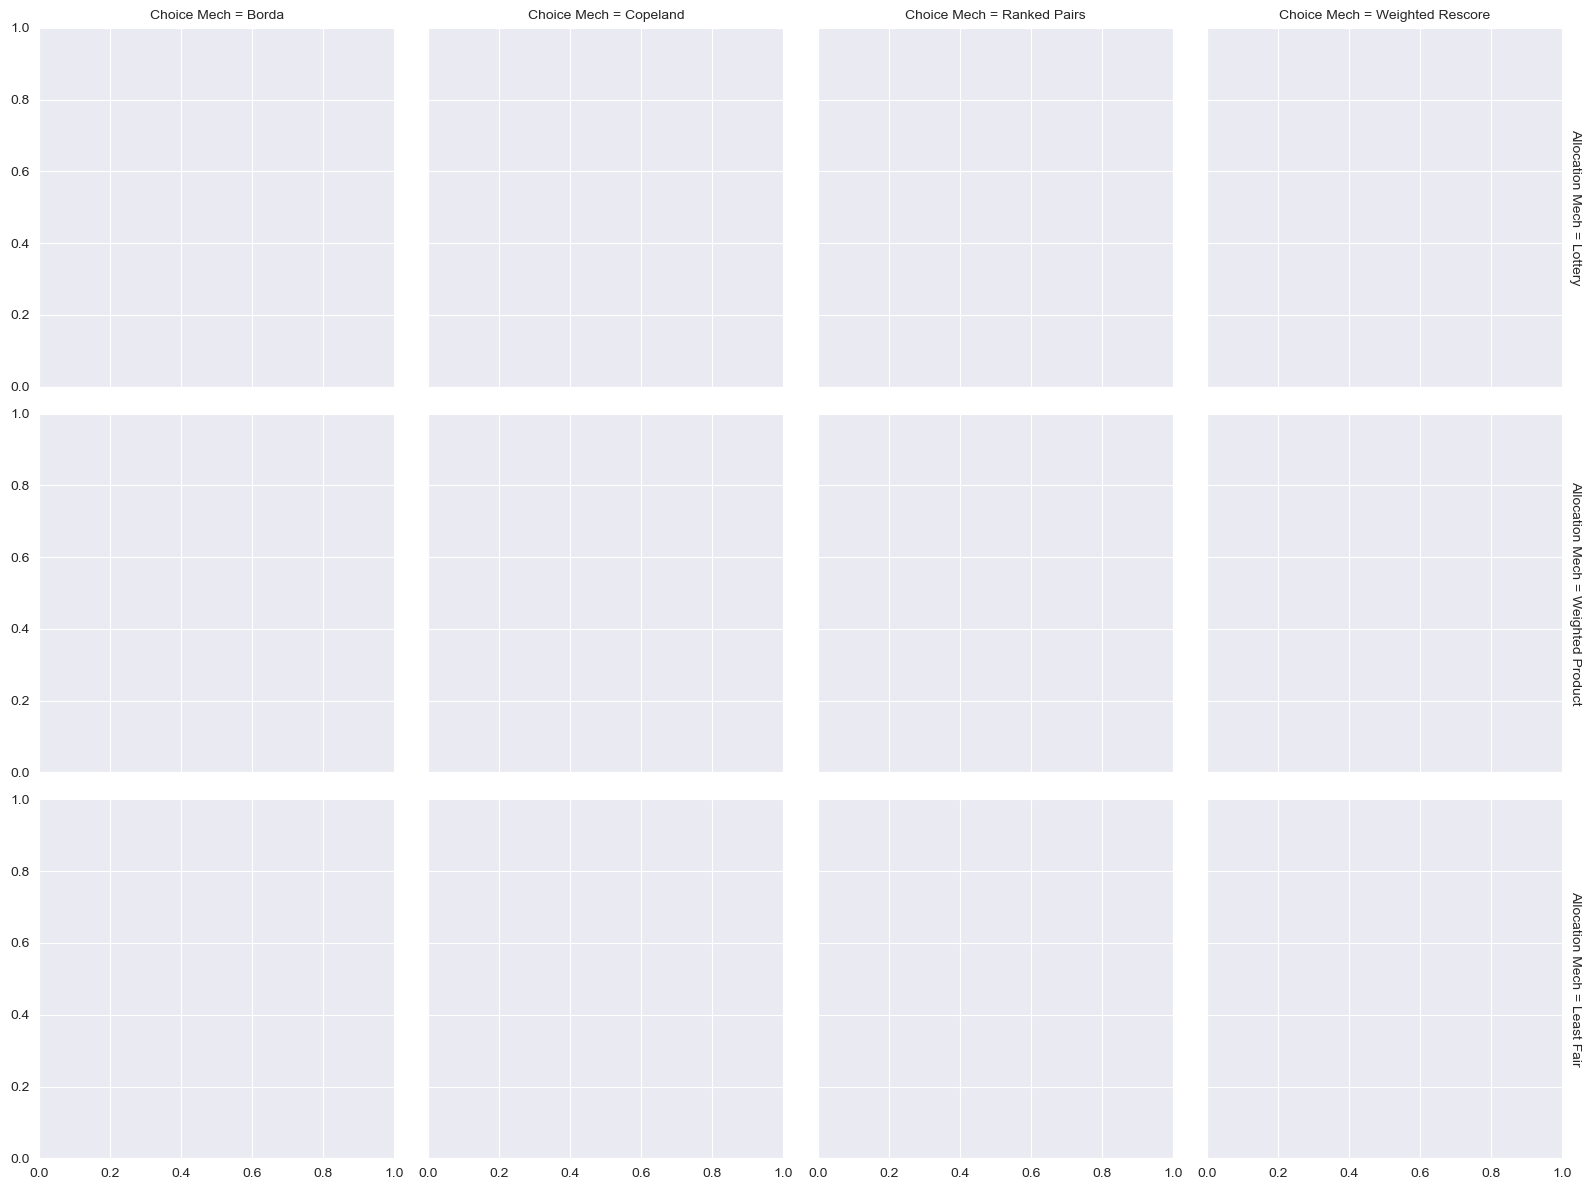

In [65]:
plt = sb.FacetGrid(no_baseline,
                           row="Allocation Mech",
                           col="Choice Mech",
                           margin_titles=True,
                           height=4,
                           aspect=1,
                   hue="Agent")

plt.map(sb.lineplot, data=no_baseline, x="Time", y="Efficiency")

#plt.map(facetgrid_two_axes, data=no_baseline, x_name="Time", y1_name="Efficiency", y2_name="Cumulative Alloc",hue="Agent)
plt.figure.subplots_adjust(wspace=.02, hspace=.02)

In [ ]:
# catplot probably doesn't support a xline parameter

In [45]:
baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "1"]["Fairness"].mean()
baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "2"]["Fairness"].mean()

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/802011469.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline1_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "1"]["Fairness"].mean()
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/802011469.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline2_mean = experiments[experiments["Allocation Mech"] == "Baseline"][experiments["Agent"] == "2"]["Fairness"].mean()


In [63]:
new_boxplots = experiments[experiments["Allocation Mech"] != "Baseline"][experiments["Fairness"] != 1.000000][experiments["Fairness"] != 0]

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/2670767572.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_boxplots = experiments[experiments["Allocation Mech"] != "Baseline"][experiments["Fairness"] != 1.000000][experiments["Fairness"] != 0]


In [78]:
new_boxplots.loc[new_boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
new_boxplots.loc[new_boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"

In [79]:
new_boxplots["Choice Mech"].value_counts()

Borda           2988
Rescoring       2988
Copeland        2987
Ranked Pairs    2987
Name: Choice Mech, dtype: int64

/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


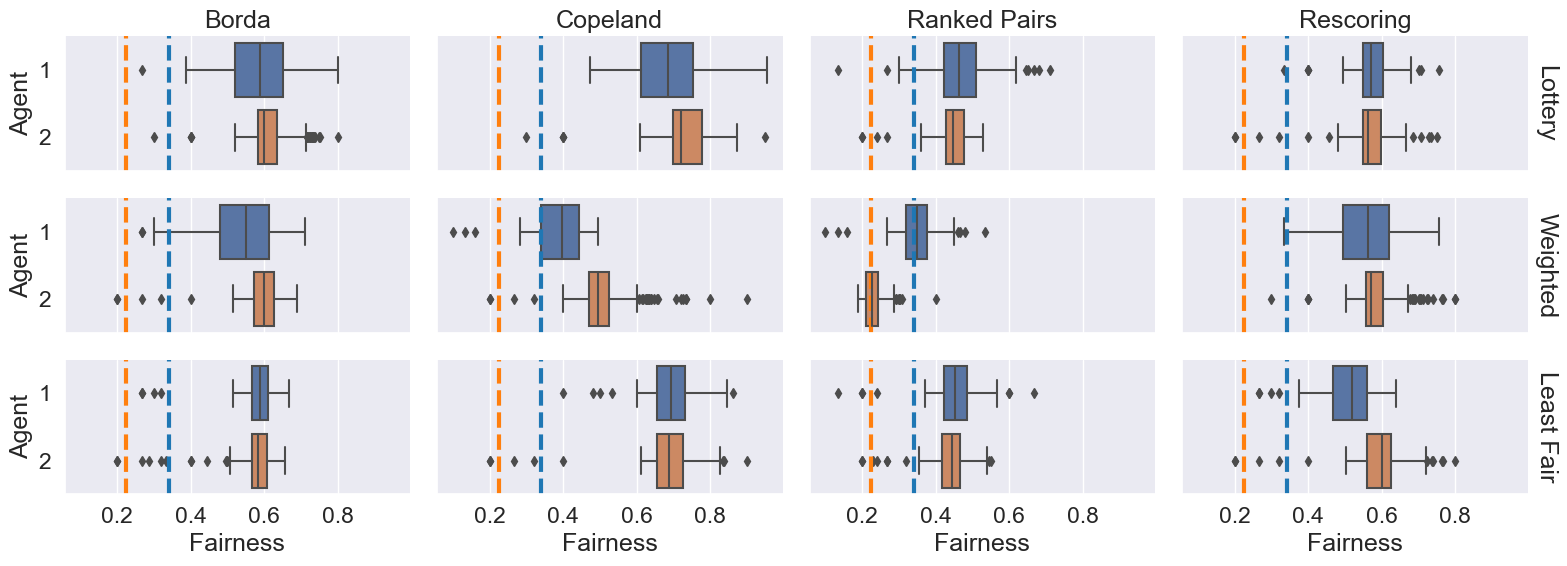

In [112]:
"""
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
"""
#matplotlib.pyplot.rcdefaults()

sb.set(font_scale=1.5)

g = sb.catplot(data=new_boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["1","2"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

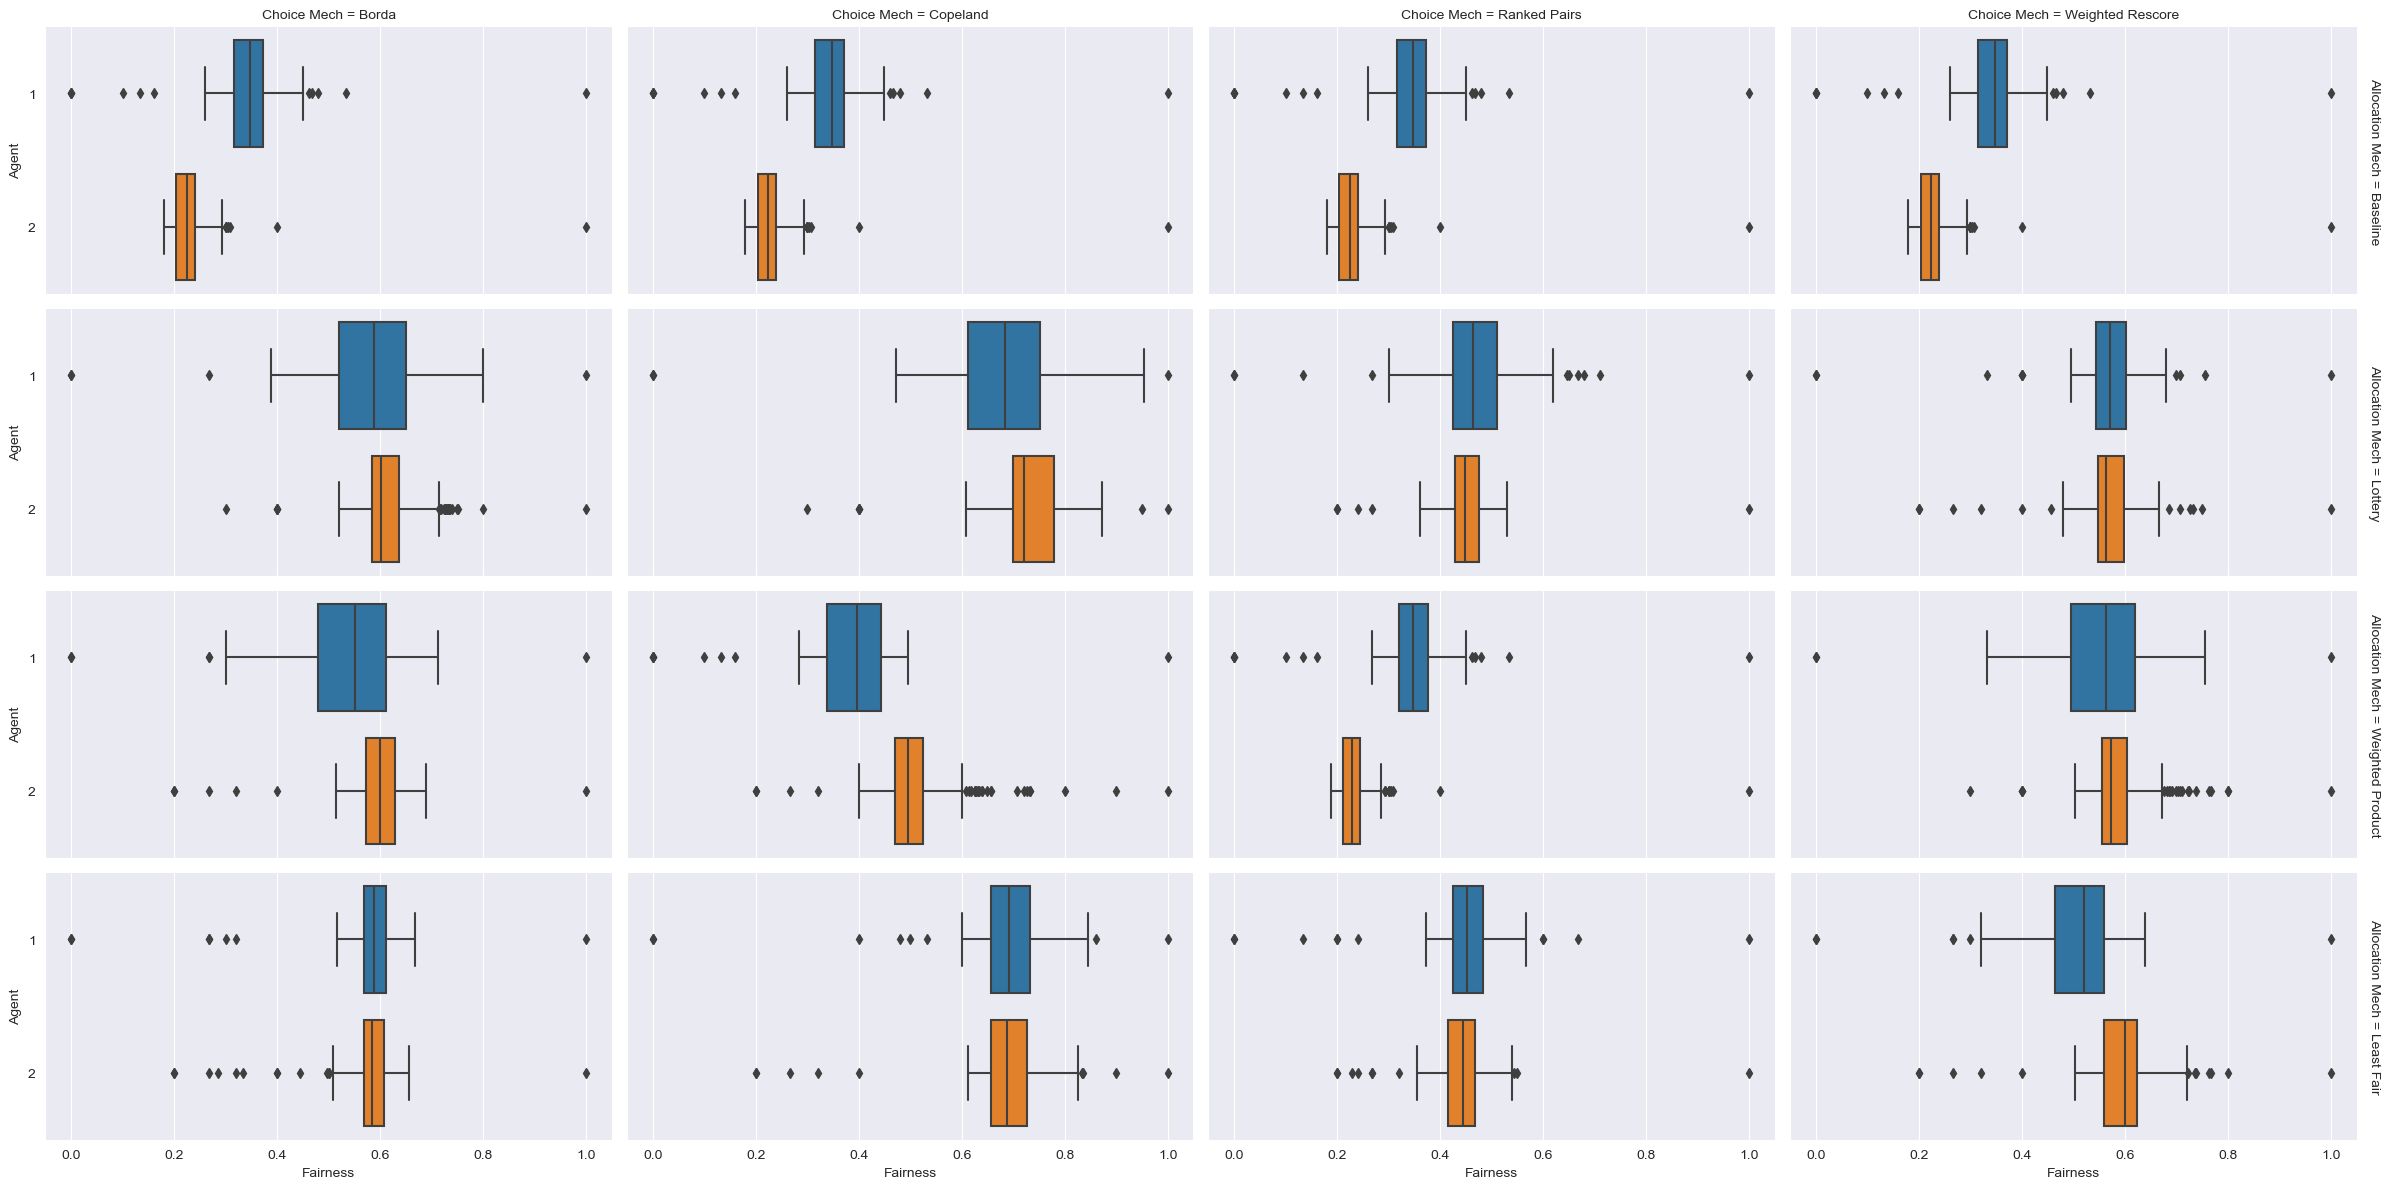

In [50]:
g = sb.catplot(data=experiments,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["1","2"],
           kind="box",
           height=3,
           aspect=2,
           margin_titles=True)

TypeError: 'Axes' object is not callable

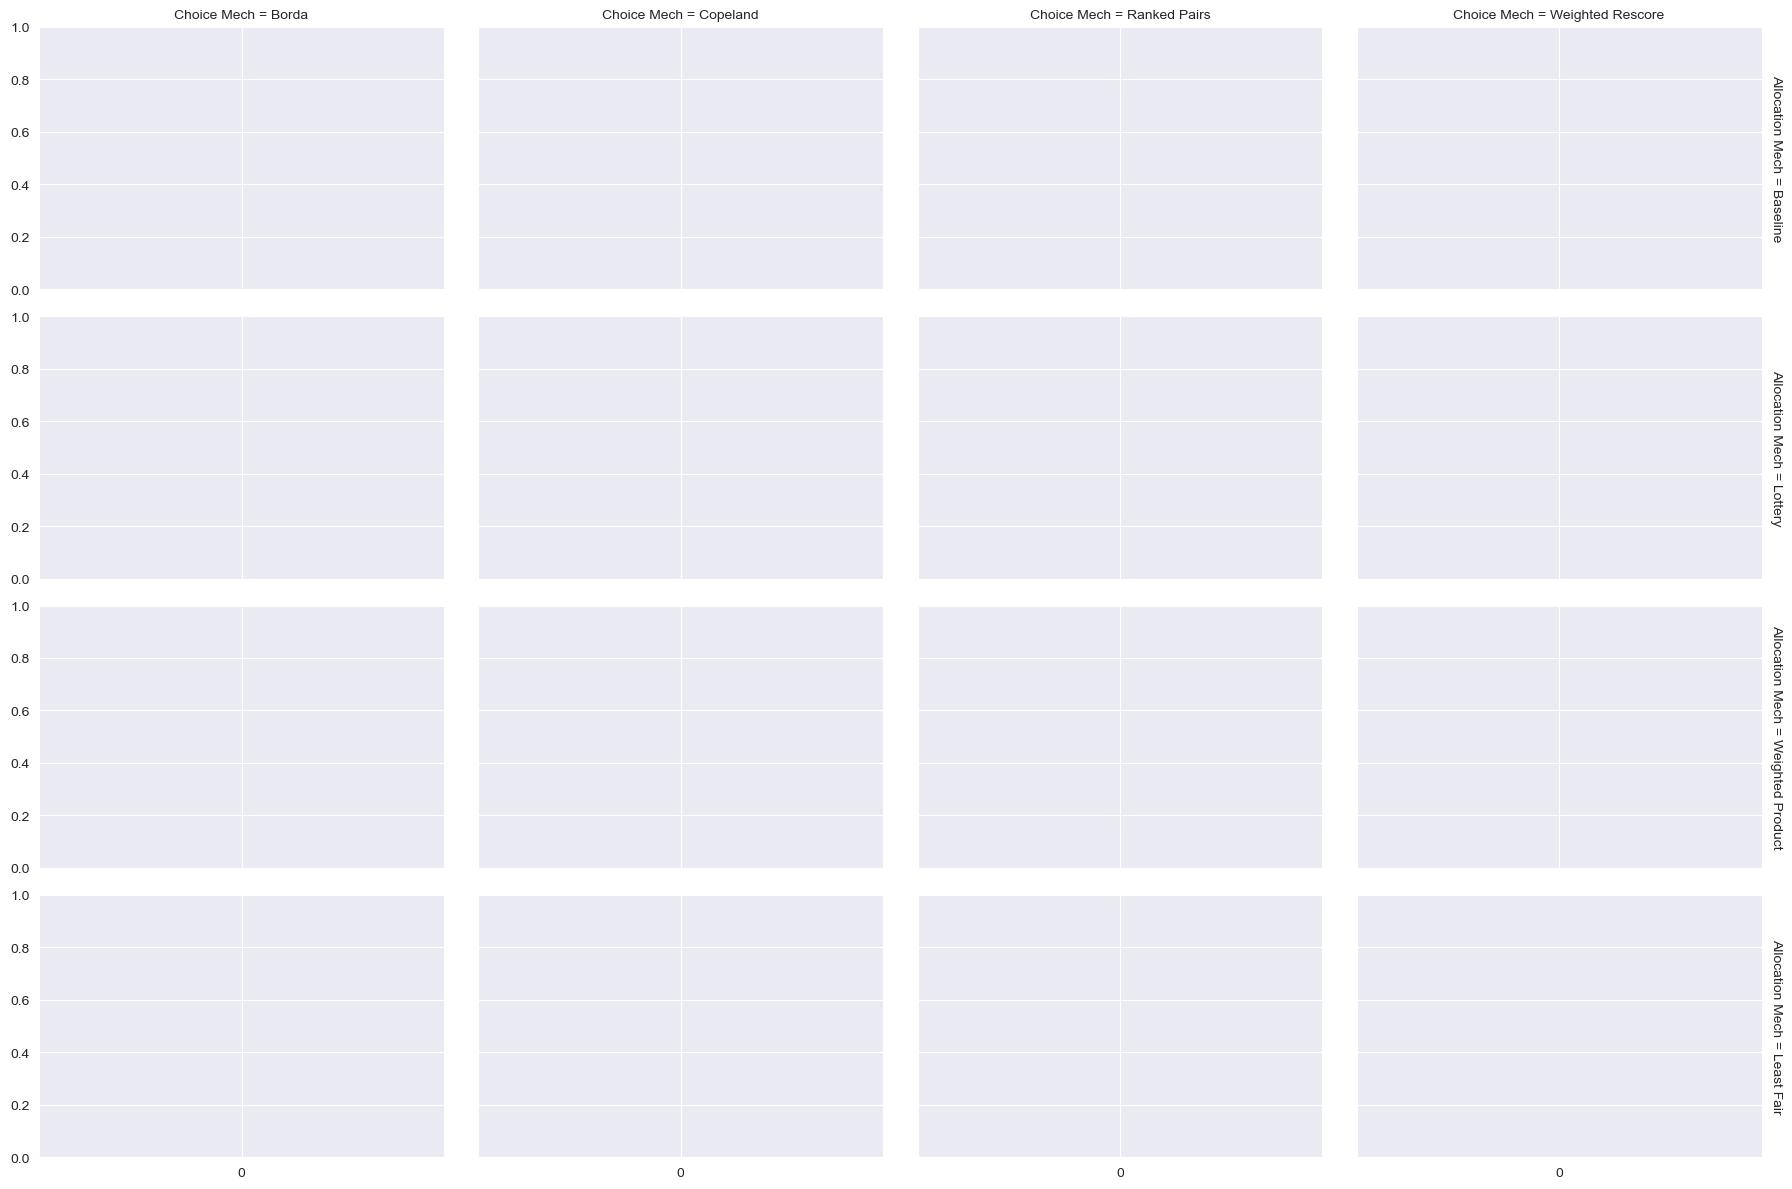

In [79]:
plt = sb.FacetGrid(experiments,
                           row="Allocation Mech",
                           col="Choice Mech",
                           margin_titles=True,
                           height=3,
                           aspect=1.5
                   )

plt.map(sb.boxplot(),
      data=experiments,
      x="Fairness",
      y="Agent",
      order=["1","2"])
plt.figure.subplots_adjust(wspace=.02, hspace=.02)

/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/categorical.py:3025: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/Users/call/anaconda3/envs/workshop/lib/python3.11/s

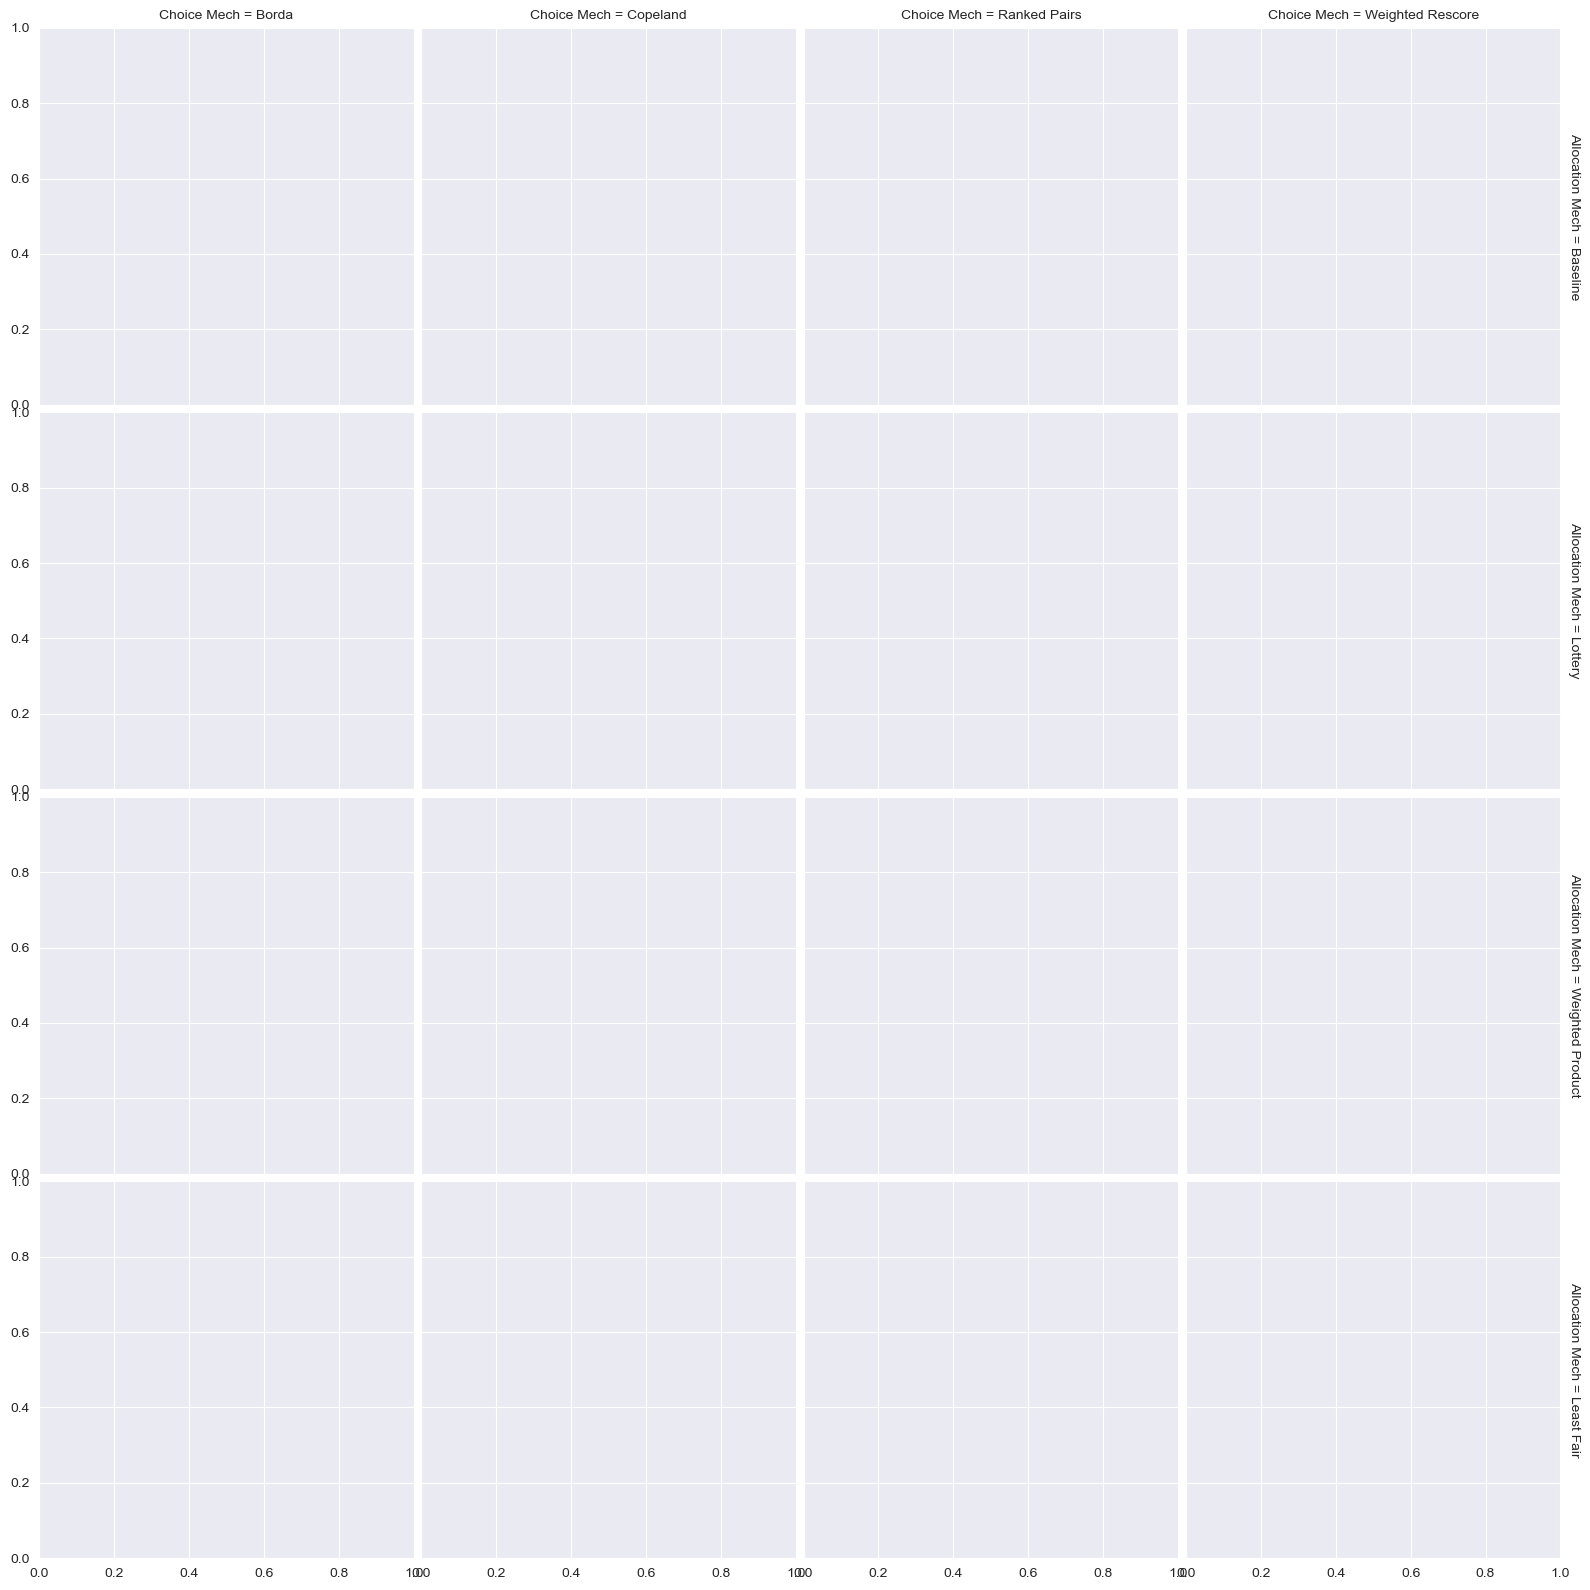

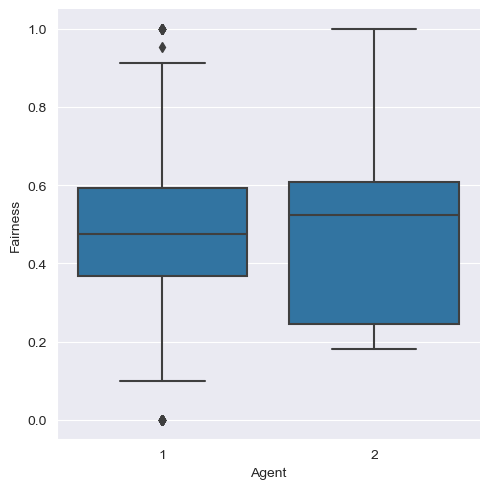

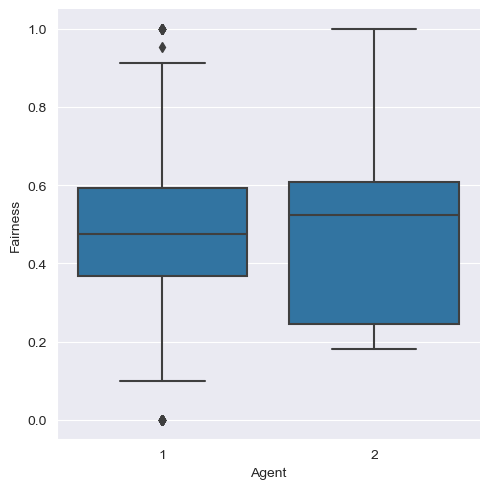

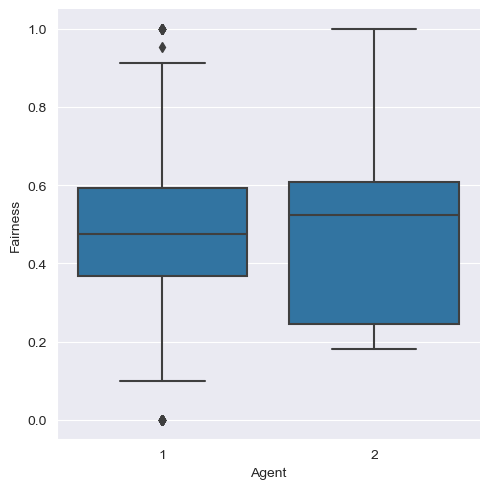

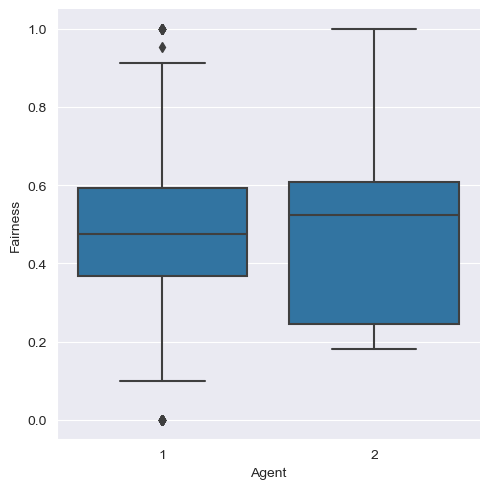

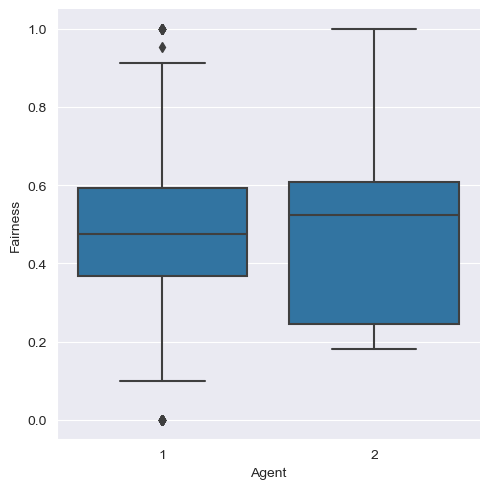

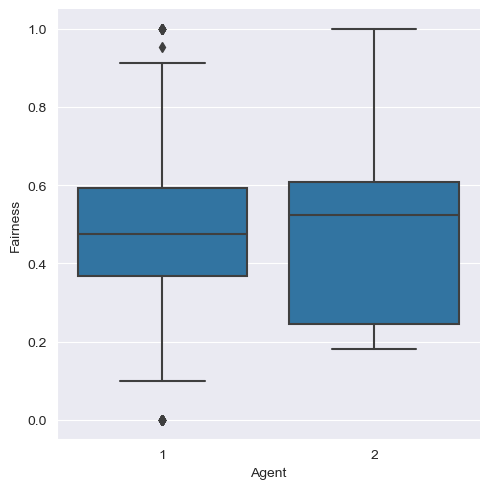

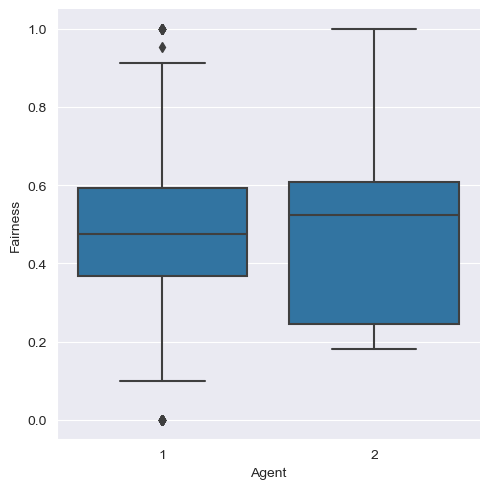

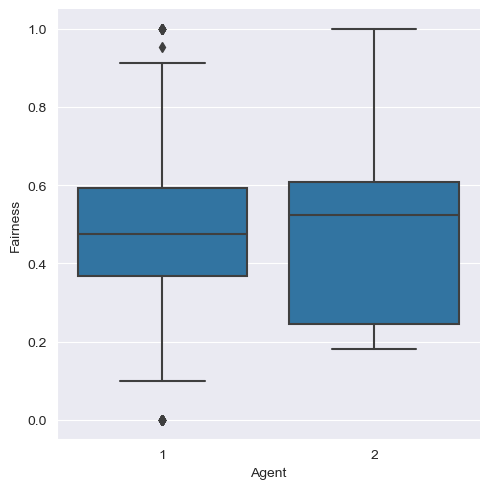

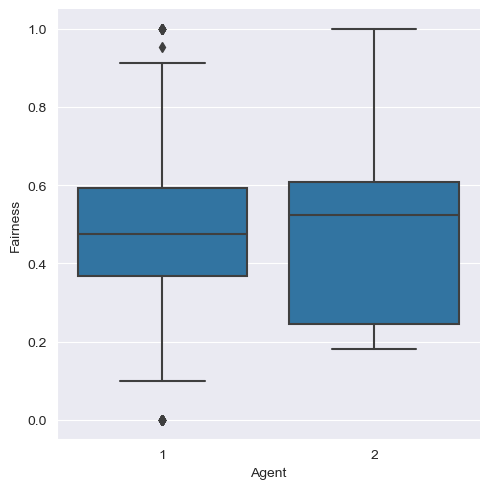

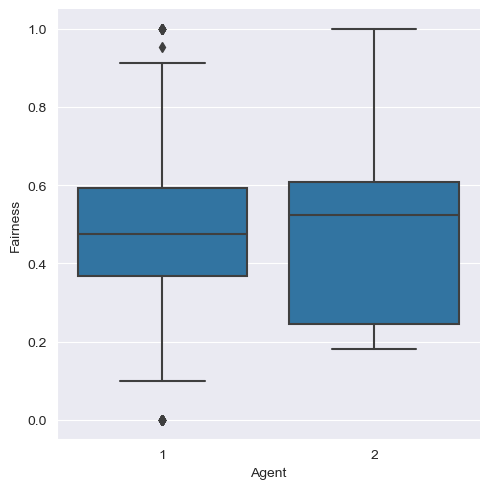

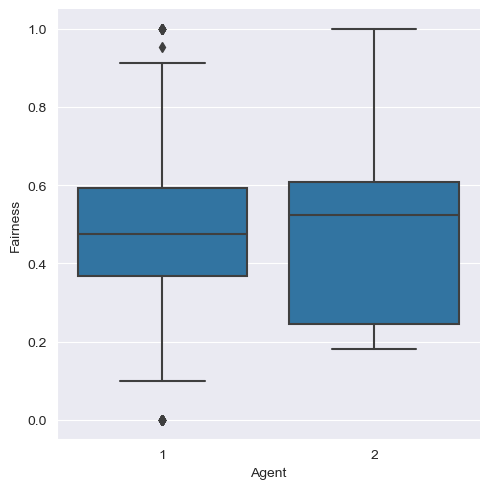

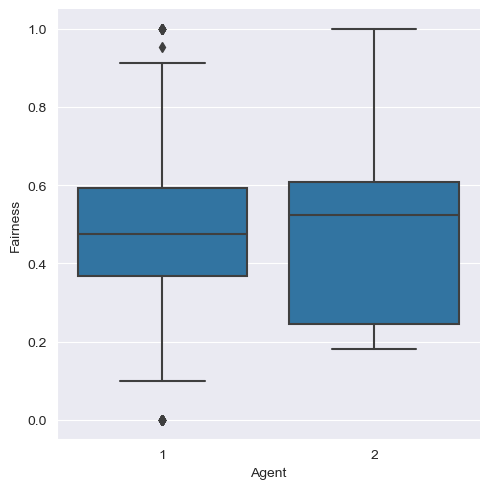

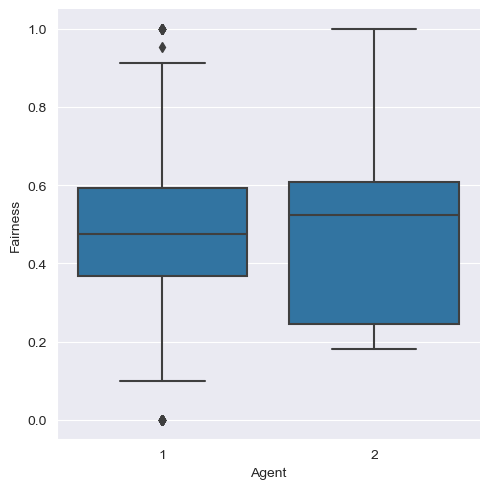

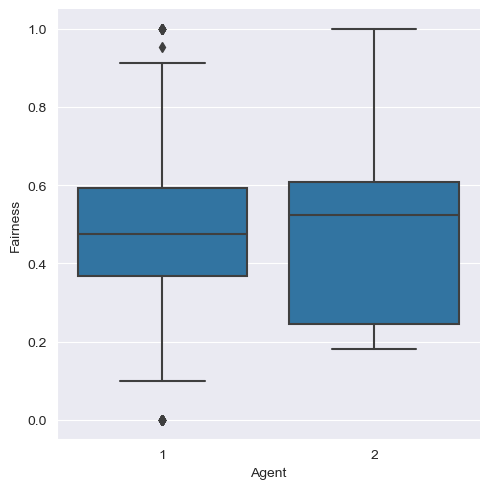

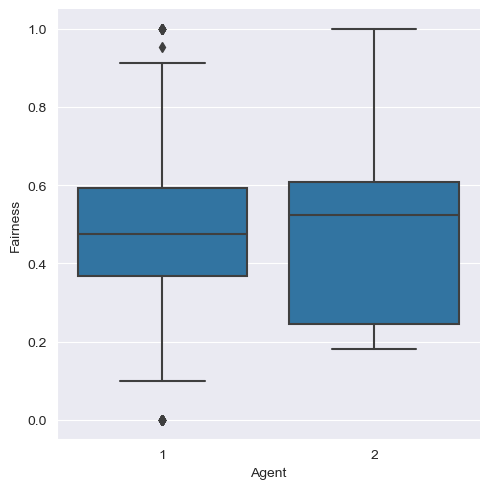

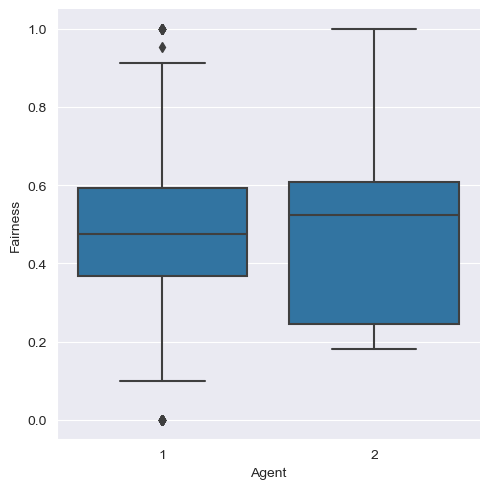

In [67]:
plot_multi(fair=True, features=["1","2"], include_none=True)

In [32]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for history, name in zip(processed_histories, mechanisms):
    users = []
    ndcg_values = []
    for user, items in processed_histories[history]["Statistics"].items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == typecast(recommender.User, user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [33]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

NDCG
Borda Baseline                     0.011640
Borda Lottery                      0.894242
Borda Weighted Product             0.894242
Borda Least Fair                   0.894242
Copeland Baseline                  0.011640
Copeland Least Fair                0.879369
Copeland Lottery                   0.879369
Copeland Weighted Product          0.879369
Ranked Pairs Baseline              0.011640
Ranked Pairs Least Fair            0.879369
Ranked Pairs Lottery               0.879369
Ranked Pairs Weighted Product      0.011611
Weighted Rescore Baseline          0.011640
Weighted Rescore Lottery           0.966684
Weighted Rescore Weighted Product  0.966684
Weighted Rescore Least Fair        0.011612

In [35]:
# calculates proportional fairness for the representation of item features
num_features = 10
feature_names = ["0","1","2","3","4","5","6","7","8","9"]
protected_features = ["0","1"]
fairness_targets = [0.20, 0.20]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [36]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [37]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [38]:
ndcg_fairness

0         1      NDCG
Borda Baseline                     0.255667  0.035667  0.011640
Borda Lottery                      4.436000  0.414000  0.894242
Borda Weighted Product             4.436000  0.414000  0.894242
Borda Least Fair                   4.436000  0.414000  0.894242
Copeland Baseline                  0.255667  0.035667  0.011640
Copeland Least Fair                4.410000  0.447000  0.879369
Copeland Lottery                   4.410000  0.447000  0.879369
Copeland Weighted Product          4.410000  0.447000  0.879369
Ranked Pairs Baseline              0.255667  0.035667  0.011640
Ranked Pairs Least Fair            4.410000  0.447000  0.879369
Ranked Pairs Lottery               4.410000  0.447000  0.879369
Ranked Pairs Weighted Product      0.255667  0.035667  0.011611
Weighted Rescore Baseline          0.255667  0.035667  0.011640
Weighted Rescore Lottery           4.657667  0.182333  0.966684
Weighted Rescore Weighted Product  4.657667  0.182333  0.966684
Weighted Rescore Least Fair        0.255667  0.035667  0.011612

In [39]:
recommender

User  Item     Score
0         0   494  0.913875
1         0   353  0.858646
2         0   829  0.835495
3         0   259  0.826287
4         0   453  0.824175
...     ...   ...       ...
74995  1499   814  0.081964
74996  1499   116  0.081062
74997  1499   357  0.077725
74998  1499   138  0.075871
74999  1499   845  0.074834

[75000 rows x 3 columns]

In [59]:
f0_items = []
f1_items = []
f0_recs = []
f1_recs = []
other_recs = []
both_items = []
for user in recommender["User"].unique():
    f0 = 0
    f1 = 0
    both = 0
    eval_frame = recommender[recommender["User"] == user][0:]
    for item, rec in zip(eval_frame["Item"], eval_frame["Score"]):
        features = get_item_features(item)
        if features[0] == 1 and features[1] == 1:
            both += 1
        elif features[0] == 1:
            f0 += 1
            f0_recs.append(rec)
        elif features[1] == 1:
            f1 += 1
            f1_recs.append(rec)
        else:
            other_recs.append(rec)
    f0_items.append(f0)
    f1_items.append(f1)
    both_items.append(both)

In [60]:
print(mean(f0_recs))
print(mean(f1_recs))
print(mean(other_recs))

0.8951704170895542
0.24305294163490904
0.1413731427541801


In [57]:
f0_items

[10,
 8,
 10,
 9,
 10,
 10,
 10,
 18,
 8,
 9,
 11,
 9,
 14,
 12,
 12,
 14,
 13,
 5,
 12,
 12,
 12,
 7,
 12,
 9,
 9,
 10,
 9,
 8,
 12,
 13,
 12,
 14,
 11,
 15,
 13,
 13,
 11,
 11,
 13,
 11,
 7,
 10,
 10,
 17,
 11,
 10,
 13,
 11,
 9,
 9,
 15,
 10,
 11,
 10,
 8,
 14,
 9,
 11,
 10,
 8,
 11,
 9,
 15,
 9,
 13,
 15,
 16,
 15,
 7,
 10,
 8,
 12,
 11,
 9,
 11,
 15,
 14,
 15,
 12,
 11,
 12,
 14,
 19,
 14,
 11,
 14,
 12,
 6,
 12,
 18,
 10,
 17,
 7,
 16,
 13,
 9,
 5,
 15,
 14,
 12,
 10,
 10,
 13,
 9,
 13,
 14,
 9,
 14,
 8,
 10,
 5,
 11,
 12,
 11,
 8,
 10,
 11,
 13,
 12,
 13,
 12,
 10,
 13,
 9,
 13,
 15,
 15,
 15,
 15,
 9,
 6,
 13,
 8,
 11,
 10,
 5,
 7,
 7,
 13,
 10,
 9,
 8,
 18,
 10,
 14,
 10,
 12,
 9,
 6,
 16,
 13,
 9,
 6,
 10,
 10,
 16,
 9,
 15,
 10,
 12,
 7,
 11,
 7,
 14,
 6,
 7,
 10,
 6,
 17,
 15,
 11,
 14,
 12,
 16,
 12,
 6,
 14,
 8,
 12,
 8,
 16,
 9,
 12,
 15,
 7,
 9,
 17,
 11,
 16,
 12,
 14,
 11,
 12,
 14,
 11,
 12,
 9,
 9,
 12,
 12,
 15,
 10,
 9,
 12,
 11,
 8,
 9,
 9,
 13,
 12,
 10,
 9,
 11

In [55]:
print(mean(f0_items))
print(mean(f1_items))
print(mean(both_items))

11.004
0.6886666666666666
0.20533333333333334


In [54]:
f0_optimal = []
for f0, f1, both in zip(f0_items, f1_items, both_items):
    if f0+both >= 10:
        fairness = 1
    else:
        fairness = (f0+both)/10
    f0_optimal.append(fairness)

mean(f0_optimal)

0.9321333333333334

In [40]:
get_item_features(494)

[1, 0, 1, 1, 0, 1, 1, 0, 1, 0]

In [121]:
baseline_accuracy = ndcg_fairness.iloc[0,2]

In [122]:
ndcg_fairness.loc[0:4, "Choice"] = "Borda"
ndcg_fairness.loc[4:8, "Choice"] = "Copeland"
ndcg_fairness.loc[8:12, "Choice"] = "Ranked Pairs"
ndcg_fairness.loc[12:16, "Choice"] = "Rescoring"

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/2484953181.py:1: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[0:4, "Choice"] = "Borda"
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/2484953181.py:2: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[4:8, "Choice"] = "Copeland"
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/2484953181.py:3: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  ndcg_fairness.loc[8:12, "Choice"] = "Ranked Pairs"
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_35169/2484953181.py:4: FutureWarning

In [123]:
#ndcg_fairness["Allocation"] = ndcg_fairness.apply(lambda x: x.name.replace(x["Choice"], ''), axis=1)

In [124]:
ndcg_fairness = ndcg_fairness.drop(["Borda Baseline", "Copeland Baseline", "Ranked Pairs Baseline", "Weighted Rescore Baseline"])

In [125]:
ndcg_fairness["Allocation"] = ''

In [133]:
ndcg_fairness

1       2      NDCG        Choice  \
Borda Lottery                      0.5840  0.6032  0.799502         Borda   
Borda Weighted Product             0.5488  0.6016  0.826576         Borda   
Borda Least Fair                   0.5952  0.5904  0.807565         Borda   
Copeland Least Fair                0.6944  0.6880  0.744433      Copeland   
Copeland Lottery                   0.6768  0.7240  0.732881      Copeland   
Copeland Weighted Product          0.3896  0.4968  0.904031      Copeland   
Ranked Pairs Least Fair            0.4544  0.4400  0.913423  Ranked Pairs   
Ranked Pairs Lottery               0.4648  0.4520  0.909284  Ranked Pairs   
Ranked Pairs Weighted Product      0.3472  0.2288  0.973418  Ranked Pairs   
Weighted Rescore Lottery           0.5720  0.5704  0.899143     Rescoring   
Weighted Rescore Weighted Product  0.5576  0.5760  0.897729     Rescoring   
Weighted Rescore Least Fair        0.5120  0.5920  0.925124     Rescoring   

                                   Allocation  
Borda Lottery                         Lottery  
Borda Weighted Product               Weighted  
Borda Least Fair                   Least Fair  
Copeland Least Fair                Least Fair  
Copeland Lottery                      Lottery  
Copeland Weighted Product            Weighted  
Ranked Pairs Least Fair            Least Fair  
Ranked Pairs Lottery                  Lottery  
Ranked Pairs Weighted Product        Weighted  
Weighted Rescore Lottery           Least Fair  
Weighted Rescore Weighted Product     Lottery  
Weighted Rescore Least Fair          Weighted

In [129]:
ndcg_fairness.iloc[0,4] = "Lottery"
ndcg_fairness.iloc[1,4] = "Weighted"
ndcg_fairness.iloc[2,4] = "Least Fair"
ndcg_fairness.iloc[3:10:3,4] = "Least Fair"
ndcg_fairness.iloc[4:11:3,4] = "Lottery"
ndcg_fairness.iloc[5:12:3,4] = "Weighted"

In [130]:
ndcg_fairness

1       2      NDCG        Choice  \
Borda Lottery                      0.5840  0.6032  0.799502         Borda   
Borda Weighted Product             0.5488  0.6016  0.826576         Borda   
Borda Least Fair                   0.5952  0.5904  0.807565         Borda   
Copeland Least Fair                0.6944  0.6880  0.744433      Copeland   
Copeland Lottery                   0.6768  0.7240  0.732881      Copeland   
Copeland Weighted Product          0.3896  0.4968  0.904031      Copeland   
Ranked Pairs Least Fair            0.4544  0.4400  0.913423  Ranked Pairs   
Ranked Pairs Lottery               0.4648  0.4520  0.909284  Ranked Pairs   
Ranked Pairs Weighted Product      0.3472  0.2288  0.973418  Ranked Pairs   
Weighted Rescore Lottery           0.5720  0.5704  0.899143     Rescoring   
Weighted Rescore Weighted Product  0.5576  0.5760  0.897729     Rescoring   
Weighted Rescore Least Fair        0.5120  0.5920  0.925124     Rescoring   

                                   Allocation  
Borda Lottery                         Lottery  
Borda Weighted Product               Weighted  
Borda Least Fair                   Least Fair  
Copeland Least Fair                Least Fair  
Copeland Lottery                      Lottery  
Copeland Weighted Product            Weighted  
Ranked Pairs Least Fair            Least Fair  
Ranked Pairs Lottery                  Lottery  
Ranked Pairs Weighted Product        Weighted  
Weighted Rescore Lottery           Least Fair  
Weighted Rescore Weighted Product     Lottery  
Weighted Rescore Least Fair          Weighted

In [ ]:
ndcg_fairness["Proportional Difference"] = ndcg_fairness.apply(lambda x: x["1"] - x["2"], axis=1)

In [ ]:
ndcg_fairness["Normalized Difference"] = ndcg_fairness.apply(lambda x: x["score1"] - x["score2"], axis=1)

In [ ]:
difference_table = ndcg_fairness[["Proportional Difference", "Normalized Difference"]]

In [ ]:
difference_table = difference_table[0:16]

In [134]:
# only for test
ndcg_fairness["Average Fairness Score"] = (ndcg_fairness["1"]+ndcg_fairness["2"])/2

In [178]:
print(ndcg_fairness)

                                        1       2      NDCG        Choice  \
Borda Lottery                      0.5840  0.6032  0.799502         Borda   
Borda Weighted Product             0.5488  0.6016  0.826576         Borda   
Borda Least Fair                   0.5952  0.5904  0.807565         Borda   
Copeland Least Fair                0.6944  0.6880  0.744433      Copeland   
Copeland Lottery                   0.6768  0.7240  0.732881      Copeland   
Copeland Weighted Product          0.3896  0.4968  0.904031      Copeland   
Ranked Pairs Least Fair            0.4544  0.4400  0.913423  Ranked Pairs   
Ranked Pairs Lottery               0.4648  0.4520  0.909284  Ranked Pairs   
Ranked Pairs Weighted Product      0.3472  0.2288  0.973418  Ranked Pairs   
Weighted Rescore Lottery           0.5720  0.5704  0.899143     Rescoring   
Weighted Rescore Weighted Product  0.5576  0.5760  0.897729     Rescoring   
Weighted Rescore Least Fair        0.5120  0.5920  0.925124     Rescoring   

In [189]:
print(ndcg_fairness["Average Fairness Score"]-ndcg_fairness["1"])

Borda Lottery                        0.0096
Borda Weighted Product               0.0264
Borda Least Fair                    -0.0024
Copeland Least Fair                 -0.0032
Copeland Lottery                     0.0236
Copeland Weighted Product            0.0536
Ranked Pairs Least Fair             -0.0072
Ranked Pairs Lottery                -0.0064
Ranked Pairs Weighted Product       -0.0592
Weighted Rescore Lottery            -0.0008
Weighted Rescore Weighted Product    0.0092
Weighted Rescore Least Fair          0.0400
dtype: float64


In [202]:
def make_scatterplot(fairness_df, base_ndcg, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"},
                          zorder=2)

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12)
    x_error = [fairness_df["Average Fairness Score"]-fairness_df["1"],fairness_df["Average Fairness Score"]-fairness_df["2"]]
    plt.errorbar(fairness_df['Average Fairness Score'],fairness_df['NDCG'],xerr=x_error, capsize=4, zorder=1, linestyle="None")
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()


ValueError: 'xerr' must not contain negative values

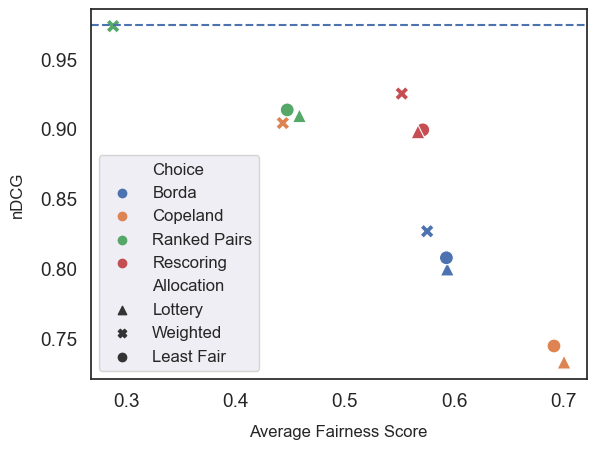

In [203]:
make_scatterplot(ndcg_fairness, baseline_accuracy, filename='synthetic_scatter.png')

In [29]:
baseline_accuracy

0.2804

In [71]:
difference_table


Proportional Difference  Normalized Difference
Borda Lottery                                  -0.0048                -0.0192
Borda Weighted Product                         -0.0132                -0.0528
Borda Least Fair                                0.0012                 0.0048
Copeland Least Fair                             0.0016                 0.0064
Copeland Lottery                               -0.0118                -0.0472
Copeland Weighted Product                      -0.0268                -0.1072
Ranked Pairs Least Fair                         0.0036                 0.0144
Ranked Pairs Lottery                            0.0032                 0.0128
Ranked Pairs Weighted Product                   0.0296                 0.1184
Weighted Rescore Lottery                        0.0004                 0.0016
Weighted Rescore Product                       -0.0046                -0.0184
Weighted Rescore Least Fair                    -0.0200                -0.0800

# Kiva experiments

In [125]:

BORDA_LOT = "../WorkshopExperiments/data/history_file_product_lottery_borda_kiva.json"
BORDA_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_borda_kiva.json"
BORDA_LEAST = "../WorkshopExperiments/data/history_file_least_fair_borda_kiva.json"


COPELAND_LOT = "../WorkshopExperiments/data/history_file_product_lottery_copeland_kiva.json"
COPELAND_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_copeland_kiva.json"
COPELAND_LEAST = "../WorkshopExperiments/data/history_file_least_fair_copeland_kiva.json"


RP_LOT = "../WorkshopExperiments/data/history_file_product_lottery_rankedpairs_kiva.json"
RP_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_rankedpairs_kiva.json"
RP_LEAST = "../WorkshopExperiments/data/history_file_least_fair_rankedpairs_kiva.json"

WEIGHT_LEAST = "../WorkshopExperiments/data/history_file_least_fair_weighted_kiva.json"
WEIGHT_LOT = "../WorkshopExperiments/data/history_file_product_lottery_rescore_kiva.json"
WEIGHT_WEIGHT = "../WorkshopExperiments/data/history_file_weighted_alloc_weighted_kiva.json"

BASELINE = "../WorkshopExperiments/data/history_file_baseline_kiva.json"

recs_file = "../kiva/data/rating_5000_cls_hc_10core_iterative.csv"
items_file = "../WorkshopExperiments/data/kiva_item.csv"

In [126]:
# reads recommender and item files
recommender = pd.read_csv(recs_file, names=["User","Item","Score"], delimiter= '\t')
item_features = pd.read_csv(items_file, names=["Item","Feature","BV"])
item_features = item_features[(item_features["Feature"]== 'COUNTRY_low_pfr') | (item_features['Feature'] == 'loan_buck_5')]

In [127]:
dataset = item_features

# Create a list of all feature combinations
all_features = ["COUNTRY_low_pfr", "loan_buck_5"]

# Iterate over each item ID and feature combination
for item_id in range(1, 4998):
    for feature in all_features:
        # Check if the row exists
        row_exists = ((dataset["Item"] == item_id) & (dataset["Feature"] == feature)).any()

        # If the row doesn't exist, add a new row with item ID, feature, and value of 0
        if not row_exists:
            dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
            
item_features = dataset

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_5029/388058623.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_5029/388058623.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_5029/388058623.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = dataset.append({"Item": item_id, "Feature": feature, "BV": 0}, ignore_index=True)\
/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_5029/388058623

In [128]:
# no need to change unless changing allocation/choice mechanism
history_files = [BORDA_LOT, BORDA_WEIGHT, BORDA_LEAST, COPELAND_LEAST,COPELAND_LOT,COPELAND_WEIGHT,RP_LEAST,RP_LOT,RP_WEIGHT,WEIGHT_LEAST, WEIGHT_LOT,WEIGHT_WEIGHT,BASELINE]


mechanisms = ['Borda Lottery', 'Borda Weighted Product',
                  'Borda Least Fair','Copeland Least Fair',
                  'Copeland Lottery', 'Copeland Weighted Product',
                  'Ranked Pairs Least Fair',
                  'Ranked Pairs Lottery', 'Ranked Pairs Weighted Product','Weighted Rescore Least Fair','Weighted Rescore Lottery',
                  'Weighted Rescore Weighted Product', 'Baseline']

In [129]:
processed_histories = {}
for mechanism in mechanisms:
    processed_histories[mechanism] = {}
    processed_histories[mechanism]["History"] = []
for history_file, mechanism in zip(history_files,mechanisms):
    with jsonlines.open(history_file) as reader:
        for obj in reader:
            processed_histories[mechanism]["History"].append(obj)

In [130]:
for mechanism in mechanisms:
    processed_histories[mechanism]["Statistics"] = {}
for mechanism in mechanisms:
    for line in processed_histories[mechanism]["History"]:
        results = line['choice_out']['results']
        results_list = []
        for result in results:
            results_list.append(result['item'])
        processed_histories[mechanism]["Statistics"][line['user']] = results_list

In [131]:
### STATISTICS FUNCTIONS ###

# implicit type detection for pandas lookups
def typecast(series, var):
    dtype = pd.api.types.infer_dtype(series)
    dtypes = {"string":str,"integer":int,"floating":float,"mixed-integer-float":float}
    if type(var) != dtypes[dtype]:
        var = dtypes[dtype](var)
    if dtype not in dtypes.keys():
        warnings.warn("Type of column "+series.name+" could not be implicitly determined. Defaulting to integer...")
        var = int(var)
    return var

# get recommendation score based on user and item ids
def lookupscore(user, item):
    score = recommender.loc[(recommender.User == typecast(recommender.User, user)) & (recommender.Item == typecast(recommender.Item, item))]
    if not score.empty:
        score = score['Score']
    else:
        score = 0.0
    return float(score)

# calculate ndcg given a list of recommended and ideal scores
def ndcg(scores1, scores2):
    idealdcg = 0.0
    recdcg = 0.0
    for index, val in enumerate(scores1):
        recdcg += (2**val - 1)/np.log2(index + 2)
    for index, val in enumerate(scores2):
         idealdcg += (2**val - 1)/np.log2(index + 2)
    if idealdcg == 0.0:
        return 0.0
    else:
        return recdcg/idealdcg

# not currently run in this file
def plot_ndcg(name,ndcg_results):
    ndcg_result = ndcg_results[name]
    ndcg_data = pd.DataFrame(ndcg_result)
    sb.lineplot(ndcg_data)
    imagefile = name + "ndcgplot.png"
    plt.savefig(imagefile)

# given an item id return a list of its features as binary values
def get_item_features(item_id):
    feature_values = []
    for value in item_features.loc[(item_features.Item == typecast(item_features.Item, item_id))]["BV"]:
        feature_values.append(value)
    return feature_values

In [132]:
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df['0'] == 0) & (alloc_df['1'] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc
### VISUALIZATION FUNCTIONS ###
# TODO: Update viz functions to make them more efficient and inline with statistics

def process_history(history, fair=True, compat=True, alloc=True, lists=True):
    if fair:
        fair_list = [entry['allocation']['fairness scores'] for entry in history]
        fair_df = pd.DataFrame(fair_list)
    else:
        fair_df = None
    if compat:
        compat_list = [entry['allocation']['compatibility scores'] for entry in history]
        compat_df = pd.DataFrame(compat_list)
    else:
        compat_df = None
    if alloc:
        alloc_list = [entry['allocation']['output'] for entry in history]
        alloc_df = pd.DataFrame(alloc_list)
        alloc_df['none'] = (alloc_df["COUNTRY_low_pfr"] == 0) & (alloc_df["loan_buck_5"] == 0)
    else:
        alloc_df = None
    if lists:
        results_list = [process_results(entry['choice_out']['results']) for entry in history]
    else:
        results_list = None
    return fair_df, compat_df, alloc_df, results_list

def process_results(result_structs):
    return [(entry['item'], entry['score']) for entry in result_structs]

def plot_fairness_time(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness")
    sb.lineplot(data=fair_df)
    image_file = image_prefix + '-fairness.png'
    plt.savefig(image_file)

def plot_allocation(experiment_data, include_none=False, image_prefix=None):
    alloc_df = pd.DataFrame(experiment_data[2])
    if include_none is False:
        if not alloc_df['none'][1:].any():
            alloc_df.drop('none', axis=1, inplace=True)
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Allocation")
    sb.lineplot(data=alloc_df.cumsum())
    image_file = image_prefix + '-allocation.png'
    plt.savefig(image_file)

def plot_fairness_regret(experiment_data, include_none=False, image_prefix=None):

    fair_df = experiment_data[0]
    regret = 1-fair_df
    fig, ax = plt.subplots(figsize=(10, 6))
    sb.set(font_scale=2)
    plt.xlabel("Time")
    plt.ylabel("Fairness Regret")
    sb.lineplot(data=regret.cumsum())
    image_file = image_prefix + '-regret.png'
    plt.savefig(image_file)

def do_plots(experiment_data, include_none=False, image_prefix=None):
    plot_fairness_time(experiment_data, include_none, image_prefix)
    plot_allocation(experiment_data, include_none, image_prefix)
    plot_fairness_regret(experiment_data, include_none, image_prefix)

def process(experiment, include_none=False, image_prefix=None):
    experiment_data = process_history(experiment)
    do_plots(experiment_data, include_none, image_prefix)

def process_names(name):
    orig_name = name
    for alloc in ["Baseline","Lottery","Weighted Product","Least Fair"]:
        name = name.replace(alloc, "")
        if name != orig_name:
            return name.rstrip(), alloc

In [133]:
# generates average NDCG for each allocation mechanism and stores them in the list avg_of_ndcg
# also creates ndcg_results, a dictionary that allows plotting NDCG over time for each mechanism
avg_of_ndcg = []
ndcg_results = {}
for history, name in zip(processed_histories, mechanisms):
    users = []
    ndcg_values = []
    for user, items in processed_histories[history]["Statistics"].items():
        scores = []
        for item in items:
            scores.append(lookupscore(user, item))
        ideal_scores = []
        for score in recommender.loc[(recommender.User == typecast(recommender.User, user))]["Score"].sort_values(ascending=False):
            ideal_scores.append(score)
            ideal_scores = ideal_scores[0:len(scores)+1]
        # if sum of denom = 0 then NDCG = 0
        ndcg_values.append(ndcg(scores, ideal_scores))
        users.append(user)
    avg_of_ndcg.append(mean(ndcg_values))
    ndcg_results[name] = {"Users":users, "NDCG":ndcg_values}

In [134]:
# creates dataframe of average NDCG values
ndcg_table = pd.DataFrame(data=avg_of_ndcg, index=mechanisms, columns=["NDCG"])
ndcg_table

NDCG
Borda Lottery                      0.045537
Borda Weighted Product             0.051375
Borda Least Fair                   0.051420
Copeland Least Fair                0.050910
Copeland Lottery                   0.041293
Copeland Weighted Product          0.051483
Ranked Pairs Least Fair            0.050910
Ranked Pairs Lottery               0.041527
Ranked Pairs Weighted Product      0.051199
Weighted Rescore Least Fair        0.050928
Weighted Rescore Lottery           0.048470
Weighted Rescore Weighted Product  0.052288
Baseline                           0.052855

In [135]:
# calculates proportional fairness for the representation of item features
num_features = 2
feature_names = ["COUNTRY_low_pfr","loan_buck_5"]
protected_features = ["COUNTRY_low_pfr","loan_buck_5"]
fairness_targets = [0.20, 0.30]

proportional_fairness = []
adj_fairness = []
for history, name in zip(processed_histories, mechanisms):
    item_counter = 0
    features = [0]*num_features
    for items in processed_histories[history]["Statistics"].values():
        for item in items:
            item_counter += 1
            for idx, val in enumerate(get_item_features(item)):
                features[idx] = features[idx] + val
    proportional = [x/item_counter for x in features]
    proportional_fairness.append(proportional)
    i = 0
    calc_adj_fairness = []
    for idx, name in enumerate(feature_names):
        if name in protected_features:
            fair_target = fairness_targets[i]
            calc_adj_fairness.append(proportional[idx]/fair_target)
            i = i+1
    adj_fairness.append(calc_adj_fairness)

In [136]:
prop_fairness_results = pd.DataFrame(data=adj_fairness, columns=protected_features, index=mechanisms)

In [137]:
ndcg_fairness = prop_fairness_results.merge(ndcg_table, left_index = True, right_index = True)

In [140]:
baseline = ndcg_fairness.loc['Baseline']

In [141]:
ndcg_fairness = ndcg_fairness.drop(['Baseline'])

In [148]:
del processed_histories["Baseline"]

In [149]:
to_analyze = ["Fairness"]
for label in to_analyze:
    experiment_data = []
    for history in processed_histories:
        choice, alloc = process_names(history)
        if label=="Fairness" or label=="Fairness Regret":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[0])
        elif label=="Allocation":
            experiment = pd.DataFrame(process_history(processed_histories[history]["History"])[2])
            if include_none is False:
                if not experiment['none'][1:].any():
                    experiment.drop('none', axis=1, inplace=True)
            experiment = experiment.cumsum()
        if label=="Fairness Regret":
            regret = (1-experiment).cumsum()
            for feature in features:
                experiment[feature] = regret[feature]
        experiment["Choice Mech"] = choice
        experiment["Allocation Mech"] = alloc
        experiment_data.append(experiment)
    experiments = pd.concat(experiment_data)
    experiments["Time"] = experiments.index
    experiments = pd.melt(experiments, id_vars=['Allocation Mech',"Choice Mech","Time"], value_vars=["COUNTRY_low_pfr","loan_buck_5"],var_name='Agent', value_name=label)
    experiments["NDCG"] = experiments.apply(lambda x: ndcg_results[x["Choice Mech"]+" "+x["Allocation Mech"]]["NDCG"][int(x["Time"])], axis=1)

In [169]:
new_boxplots = experiments[experiments["Allocation Mech"] != "Baseline"][experiments["Fairness"] != 1.000000][experiments["Fairness"] != 0]
new_boxplots.loc[new_boxplots["Choice Mech"] == "Weighted Rescore", "Choice Mech"] = "Rescoring"
new_boxplots.loc[new_boxplots["Allocation Mech"] == "Weighted Product", "Allocation Mech"] = "Weighted"

/var/folders/s7/pyqqk9f55cd2c7wdwc92655c0000gn/T/ipykernel_5029/1004450666.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  new_boxplots = experiments[experiments["Allocation Mech"] != "Baseline"][experiments["Fairness"] != 1.000000][experiments["Fairness"] != 0]


In [171]:
baseline1_mean = 0.765418
baseline2_mean = 0.011985

/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/call/anaconda3/envs/workshop/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


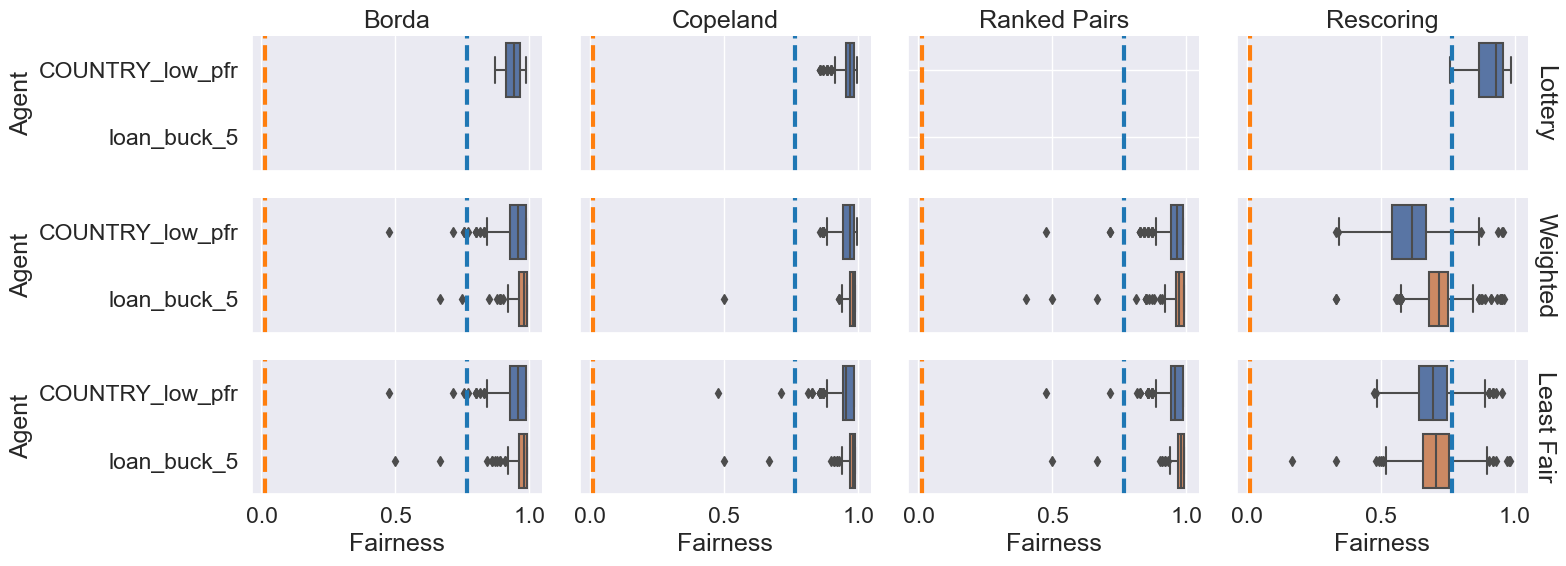

In [172]:
"""
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)
"""
#matplotlib.pyplot.rcdefaults()

sb.set(font_scale=1.5)

g = sb.catplot(data=new_boxplots,
           row="Allocation Mech",
           col="Choice Mech",
           x="Fairness",
           y="Agent",
           order=["COUNTRY_low_pfr","loan_buck_5"],
           kind="box",
           height=2,
           aspect=2,
           margin_titles=True)

for ax in g.axes.flat:
    ax.axvline(x=baseline1_mean, color='tab:blue', ls="dashed", lw=3)
    ax.axvline(x=baseline2_mean, color='tab:orange', ls="dashed", lw=3)

g.set_titles(row_template='{row_name}', col_template='{col_name}')
g.tight_layout()

In [150]:
ndcg_fairness['Choice'] = ('Borda', 'Borda', 'Borda', 'Copeland', 'Copeland', 'Copeland', 'Ranked Pairs', 'Ranked Pairs', 'Ranked Pairs', 'Rescoring', 'Rescoring', 'Rescoring')
ndcg_fairness['Allocation'] = ('Lottery', 'Weighted', 'Least Fair', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted', 'Least Fair', 'Lottery', 'Weighted')

In [151]:
ndcg_fairness["Proportional Difference"] = ndcg_fairness.apply(lambda x: x["COUNTRY_low_pfr"] - x["loan_buck_5"], axis=1)

In [166]:
ndcg_fairness["Average Fairness Score"] = ndcg_fairness.apply(lambda x: (x["COUNTRY_low_pfr"]+x["loan_buck_5"])/2, axis=1)

In [43]:
difference_table = ndcg_fairness[["Proportional Difference", "Normalized Difference"]]

In [44]:
difference_table = difference_table[0:16]

In [161]:
ndcg_fairness

COUNTRY_low_pfr  loan_buck_5      NDCG  \
Borda Lottery                             1.734831     0.061673  0.045537   
Borda Weighted Product                    0.923471     0.019559  0.051375   
Borda Least Fair                          0.926342     0.018560  0.051420   
Copeland Least Fair                       0.930337     0.019476  0.050910   
Copeland Lottery                          2.303870     0.091802  0.041293   
Copeland Weighted Product                 0.913983     0.019725  0.051483   
Ranked Pairs Least Fair                   0.930337     0.019476  0.050910   
Ranked Pairs Lottery                      2.127466     0.084644  0.041527   
Ranked Pairs Weighted Product             0.927591     0.019892  0.051199   
Weighted Rescore Least Fair               1.664295     0.057595  0.050928   
Weighted Rescore Lottery                  1.806367     0.065501  0.048470   
Weighted Rescore Weighted Product         1.576280     0.066334  0.052288   

                                         Choice  Allocation  \
Borda Lottery                             Borda     Lottery   
Borda Weighted Product                    Borda    Weighted   
Borda Least Fair                          Borda  Least Fair   
Copeland Least Fair                    Copeland  Least Fair   
Copeland Lottery                       Copeland     Lottery   
Copeland Weighted Product              Copeland    Weighted   
Ranked Pairs Least Fair            Ranked Pairs  Least Fair   
Ranked Pairs Lottery               Ranked Pairs     Lottery   
Ranked Pairs Weighted Product      Ranked Pairs    Weighted   
Weighted Rescore Least Fair           Rescoring  Least Fair   
Weighted Rescore Lottery              Rescoring     Lottery   
Weighted Rescore Weighted Product     Rescoring    Weighted   

                                   Proportional Difference  
Borda Lottery                                     1.673159  
Borda Weighted Product                            0.903912  
Borda Least Fair                                  0.907782  
Copeland Least Fair                               0.910861  
Copeland Lottery                                  2.212068  
Copeland Weighted Product                         0.894257  
Ranked Pairs Least Fair                           0.910861  
Ranked Pairs Lottery                              2.042821  
Ranked Pairs Weighted Product                     0.907699  
Weighted Rescore Least Fair                       1.606700  
Weighted Rescore Lottery                          1.740866  
Weighted Rescore Weighted Product                 1.509946

In [167]:
def make_scatterplot(fairness_df, base_ndcg, base_fair, filename=None):
    sb.set_style("white")
    plot = sb.scatterplot(x='Average Fairness Score',
                      y='NDCG',
                      data=fairness_df,
                      style="Allocation",
                      hue="Choice",
                      s=100,
                      markers={"Lottery": "^", "Weighted": "X", "Least Fair": "o"})

    sb.set(font_scale = 1.25)
    plt.axhline(y = base_ndcg, linestyle="dashed")
    plt.axvline(x = base_fair, linestyle="dashed")
    plt.xlabel("Average Fairness Score", fontsize=12, labelpad=10)
    plt.ylabel("nDCG", fontsize=12, labelpad=11)
    plt.legend(loc="lower left", fontsize=12)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

In [157]:
baseline

COUNTRY_low_pfr    0.765418
loan_buck_5        0.011985
NDCG               0.052855
Name: Baseline, dtype: float64

In [158]:
(0.765418+0.011985)/2

0.38870150000000003

In [159]:
baseline_accuracy = 0.052855
baseline_fairness = 0.388702

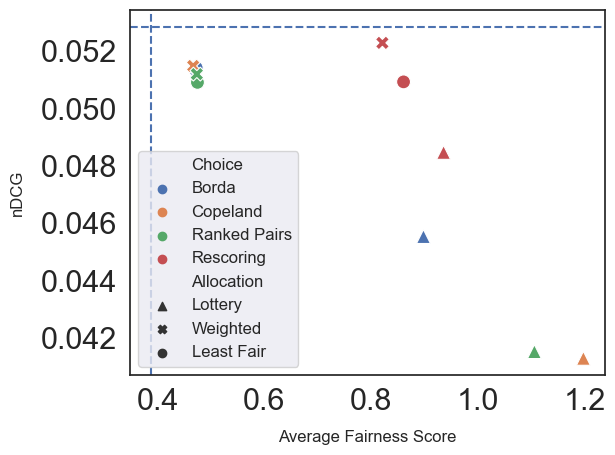

In [168]:
make_scatterplot(ndcg_fairness, baseline_accuracy, baseline_fairness, filename='kiva_scatter.png')

In [54]:
difference_table

Proportional Difference  \
Borda Lottery                                     0.327441   
Borda Weighted Product                            0.322622   
Borda Least Fair                                  0.331935   
Copeland Least Fair                               0.398027   
Copeland Lottery                                  0.433233   
Copeland Weighted Product                         0.176879   
Ranked Pairs Least Fair                           0.398027   
Ranked Pairs Lottery                              0.399051   
Ranked Pairs Weighted Product                     0.149738   
Weighted Rescore Least Fair                       0.315581   
Weighted Rescore Lottery                          0.380175   
Weighted Rescore Weighted Product                 0.295181   
Baseline                                          0.149488   

                                   Normalized Difference  
Borda Lottery                                   1.668539  
Borda Weighted Product                          1.644444  
Borda Least Fair                                1.690970  
Copeland Least Fair                             2.031918  
Copeland Lottery                                2.212068  
Copeland Weighted Product                       0.894257  
Ranked Pairs Least Fair                         2.031918  
Ranked Pairs Lottery                            2.038618  
Ranked Pairs Weighted Product                   0.757511  
Weighted Rescore Least Fair                     1.606700  
Weighted Rescore Lottery                        1.940033  
Weighted Rescore Weighted Product               1.508989  
Baseline                                        0.753433